<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Saving WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Savi

## Import packages

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Get data at pattern for training & testing

In [ ]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,52.009998,52.419998,52.919998,53.029999,52.950001,52.459999,52.560001,52.900002,51.930000,51.560001,51.180000,51.320000,51.509998,51.340000,51.700001,52.320000,52.320000,52.270000,51.720001,51.900002,51.509998,51.740002,51.740002,51.759998,51.810001,51.580002,51.240002,51.860001,51.599998,51.160000,51.910000
1,12.880000,12.500000,12.580000,12.470000,12.330000,12.430000,12.500000,12.320000,12.710000,12.600000,12.560000,12.220000,12.470000,12.530000,12.370000,12.610000,12.610000,12.550000,12.350000,12.250000,12.340000,12.380000,12.470000,12.770000,12.740000,12.610000,12.550000,12.460000,12.240000,12.220000,12.270000
2,17.340000,17.110001,16.889999,17.000000,17.090000,16.910000,16.549999,16.850000,16.889999,16.719999,17.100000,17.090000,17.070000,16.980000,16.870001,16.920000,17.090000,17.010000,16.940001,16.870001,17.030001,17.080000,17.059999,16.559999,16.620001,16.740000,16.700001,16.559999,16.530001,16.410000,16.389999
3,356.529999,360.299988,363.000000,358.779999,369.489990,382.940002,375.630005,379.760010,378.850006,384.200012,386.410004,384.440002,379.390015,377.029999,381.649994,386.200012,386.890015,382.859985,380.470001,374.940002,367.359985,372.070007,375.700012,376.540009,374.100006,374.959991,371.000000,374.920013,373.179993,370.959991,372.429993
4,54.169998,54.389999,54.310001,54.439999,54.650002,53.080002,53.840000,54.540001,53.869999,53.580002,53.830002,53.660000,53.299999,53.299999,53.509998,53.490002,53.790001,54.779999,54.230000,53.849998,54.639999,54.610001,53.750000,53.570000,53.410000,53.939999,54.430000,53.900002,53.139999,52.419998,52.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,47.146622,46.848114,47.778755,48.323090,48.375767,48.700615,48.560139,47.884109,48.024582,47.339771,47.348553,47.831432,47.568043,48.867428,48.955223,49.165936,49.578579,48.665497,48.744514,48.656715,48.683056,48.621597,49.025459,48.884987,49.201054,49.912205,49.604916,49.253731,48.744514,48.507462,48.647938
9975,194.449997,195.380005,195.580002,195.600006,194.919998,193.539993,194.130005,194.289993,194.830002,196.259995,196.479996,195.940002,195.880005,194.699997,195.580002,195.440002,195.820007,195.720001,197.029999,197.229996,198.199997,197.509995,196.240005,197.119995,196.339996,196.610001,197.600006,197.229996,197.960007,195.710007,197.710007
9976,43.630001,43.520000,43.389999,43.180000,43.500000,42.720001,43.189999,42.430000,42.820000,42.209999,41.330002,41.689999,41.009998,40.400002,40.730000,40.610001,41.330002,41.950001,41.759998,41.500000,41.070000,40.900002,41.740002,41.630001,42.189999,41.220001,41.360001,41.669998,41.020000,40.740002,41.900002
9977,135.820007,134.779999,137.380005,135.479996,136.270004,138.009995,135.869995,133.229996,136.169998,134.880005,137.070007,136.889999,135.949997,137.750000,139.080002,140.729996,140.660004,139.750000,143.970001,143.710007,146.130005,141.779999,141.279999,141.149994,142.330002,144.059998,142.800003,143.779999,144.559998,142.589996,144.279999


In [ ]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.05 #@param {type:"number"}

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        y_val = a * x_data[i] + b
        err = abs(y_val - y_data[i])
        if (err > trend_delta * y_val):
            b_is_trend = False
            break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [ ]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [ ]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_tops = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [ ]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [ ]:
for i, row in price_patterns_df.iterrows():
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)

Streaming output truncated to the last 5000 lines.
4979 [(22, 23, 25, 26, 29)] [(14, 16, 17, 18, 20)]
4980 [(14, 15, 17, 18, 19), (14, 18, 19, 21, 22), (14, 18, 22, 25, 30), (14, 21, 22, 25, 30)] []
4981 [(11, 12, 17, 20, 24)] []
4982 [(15, 16, 18, 19, 20), (15, 17, 18, 19, 20), (15, 19, 22, 25, 29)] [(4, 5, 6, 9, 13)]
4983 [] []
4984 [(10, 12, 14, 16, 19), (8, 16, 19, 22, 24), (8, 22, 24, 25, 29)] []
4985 [(13, 16, 18, 23, 29)] []
4986 [] []
4987 [(14, 17, 20, 24, 29), (14, 17, 20, 26, 29), (22, 26, 27, 28, 29)] []
4988 [(1, 3, 4, 5, 14)] []
4989 [(18, 21, 22, 23, 29)] [(21, 22, 23, 24, 25)]
4990 [(23, 24, 26, 28, 29), (23, 25, 26, 28, 29)] [(22, 23, 24, 26, 28), (22, 23, 24, 27, 28)]
4991 [(9, 19, 24, 25, 29)] [(3, 5, 6, 7, 11)]
4992 [(10, 16, 19, 22, 29)] [(1, 5, 6, 8, 16), (1, 8, 16, 19, 21)]
4993 [(24, 25, 27, 28, 29)] []
4994 [(3, 4, 5, 7, 10), (19, 22, 23, 24, 25), (19, 24, 25, 26, 29), (25, 26, 27, 28, 29)] [(2, 3, 4, 5, 7), (2, 3, 7, 10, 19), (2, 5, 7, 10, 19)]
4995 [(18, 22, 

In [ ]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0      52.009998   52.419998   52.919998  ...   51.860001   51.599998   51.160000
1      12.880000   12.500000   12.580000  ...   12.460000   12.240000   12.220000
2      17.340000   17.110001   16.889999  ...   16.559999   16.530001   16.410000
3     356.529999  360.299988  363.000000  ...  374.920013  373.179993  370.959991
4      54.169998   54.389999   54.310001  ...   53.900002   53.139999   52.419998
...          ...         ...         ...  ...         ...         ...         ...
9974   47.146622   46.848114   47.778755  ...   49.253731   48.744514   48.507462
9975  194.449997  195.380005  195.580002  ...  197.229996  197.960007  195.710007
9976   43.630001   43.520000   43.389999  ...   41.669998   41.020000   40.740002
9977  135.820007  134.779999  137.380005  ...  143.779999  144.559998  142.589996
9978   88.790001   88.879997   89.000000  ...   90.980003   90.349998   89.519997

[9979 rows x 30

In [ ]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(7983, 30) (7983, 1)
(7983, 30) (7983, 1)
(1996, 30) (1996, 1)
(1996, 30) (1996, 1)


## LSTM model

### Build model

In [ ]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 6000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/6000
1/1 [==============================] - 24s 24s/step - loss: 0.2696 - val_loss: 0.2107

Epoch 00001: val_loss improved from inf to 0.21068, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.2239 - val_loss: 0.1777

Epoch 00002: val_loss improved from 0.21068 to 0.17765, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1897 - val_loss: 0.1513

Epoch 00003: val_loss improved from 0.17765 to 0.15128, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1643 - val_loss: 0.1336

Epoch 00004: val_loss improved from 0.15128 to 0.13361, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 5/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1456 - val_loss: 0.1328

Epoch 00005: val_loss improved from 0.13361 to 0.13285, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 6/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1448 - val_loss: 0.1415

Epoch 00006: val_loss did not improve from 0.13285
Epoch 7/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.1561 - val_loss: 0.1379

Epoch 00007: val_loss did not improve from 0.13285
Epoch 8/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.1542 - val_loss: 0.1295

Epoch 00008: val_loss improved from 0.13285 to 0.12949, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 9/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1435 - val_loss: 0.1250

Epoch 00009: val_loss improved from 0.12949 to 0.12501, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 10/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1379 - val_loss: 0.1254

Epoch 00010: val_loss did not improve from 0.12501
Epoch 11/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.1380 - val_loss: 0.1276

Epoch 00011: val_loss did not improve from 0.12501
Epoch 12/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.1410 - val_loss: 0.1289

Epoch 00012: val_loss did not improve from 0.12501
Epoch 13/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.1411 - val_loss: 0.1280

Epoch 00013: val_loss did not improve from 0.12501
Epoch 14/6000
1/1 [==============================] - 0s 121ms/step - loss: 0.1409 - val_loss: 0.1256

Epoch 00014: val_loss did not improve from 0.12501
Epoch 15/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.1375 - val_loss: 0.1227

Epoch 00015: val_loss improved from 0.12501 to 0.12268, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 16/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1343 - val_loss: 0.1205

Epoch 00016: val_loss improved from 0.12268 to 0.12048, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 17/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.1321 - val_loss: 0.1197

Epoch 00017: val_loss improved from 0.12048 to 0.11970, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 18/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1302 - val_loss: 0.1201

Epoch 00018: val_loss did not improve from 0.11970
Epoch 19/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.1324 - val_loss: 0.1206

Epoch 00019: val_loss did not improve from 0.11970
Epoch 20/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.1320 - val_loss: 0.1199

Epoch 00020: val_loss did not improve from 0.11970
Epoch 21/6000
1/1 [==============================] - 0s 122ms/step - loss: 0.1312 - val_loss: 0.1181

Epoch 00021: val_loss improved from 0.11970 to 0.11808, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 22/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1293 - val_loss: 0.1160

Epoch 00022: val_loss improved from 0.11808 to 0.11605, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 23/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.1262 - val_loss: 0.1146

Epoch 00023: val_loss improved from 0.11605 to 0.11463, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 24/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1259 - val_loss: 0.1140

Epoch 00024: val_loss improved from 0.11463 to 0.11396, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 25/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.1258 - val_loss: 0.1137

Epoch 00025: val_loss improved from 0.11396 to 0.11365, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 26/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1242 - val_loss: 0.1130

Epoch 00026: val_loss improved from 0.11365 to 0.11304, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 27/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1246 - val_loss: 0.1117

Epoch 00027: val_loss improved from 0.11304 to 0.11169, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 28/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1231 - val_loss: 0.1096

Epoch 00028: val_loss improved from 0.11169 to 0.10962, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 29/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1217 - val_loss: 0.1074

Epoch 00029: val_loss improved from 0.10962 to 0.10736, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 30/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1194 - val_loss: 0.1055

Epoch 00030: val_loss improved from 0.10736 to 0.10552, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 31/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1172 - val_loss: 0.1042

Epoch 00031: val_loss improved from 0.10552 to 0.10418, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 32/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1174 - val_loss: 0.1026

Epoch 00032: val_loss improved from 0.10418 to 0.10263, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 33/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1172 - val_loss: 0.1001

Epoch 00033: val_loss improved from 0.10263 to 0.10014, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 34/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1141 - val_loss: 0.0977

Epoch 00034: val_loss improved from 0.10014 to 0.09766, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 35/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.1119 - val_loss: 0.0966

Epoch 00035: val_loss improved from 0.09766 to 0.09659, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 36/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1106 - val_loss: 0.0958

Epoch 00036: val_loss improved from 0.09659 to 0.09582, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 37/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1108 - val_loss: 0.0937

Epoch 00037: val_loss improved from 0.09582 to 0.09373, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 38/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1077 - val_loss: 0.0928

Epoch 00038: val_loss improved from 0.09373 to 0.09279, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 39/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1067 - val_loss: 0.0934

Epoch 00039: val_loss did not improve from 0.09279
Epoch 40/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1084 - val_loss: 0.0922

Epoch 00040: val_loss improved from 0.09279 to 0.09218, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 41/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1074 - val_loss: 0.0923

Epoch 00041: val_loss did not improve from 0.09218
Epoch 42/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.1065 - val_loss: 0.0926

Epoch 00042: val_loss did not improve from 0.09218
Epoch 43/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1070 - val_loss: 0.0918

Epoch 00043: val_loss improved from 0.09218 to 0.09179, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 44/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.1059 - val_loss: 0.0917

Epoch 00044: val_loss improved from 0.09179 to 0.09170, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 45/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1066 - val_loss: 0.0916

Epoch 00045: val_loss improved from 0.09170 to 0.09162, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 46/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1056 - val_loss: 0.0914

Epoch 00046: val_loss improved from 0.09162 to 0.09139, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 47/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1056 - val_loss: 0.0917

Epoch 00047: val_loss did not improve from 0.09139
Epoch 48/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.1044 - val_loss: 0.0917

Epoch 00048: val_loss did not improve from 0.09139
Epoch 49/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.1053 - val_loss: 0.0912

Epoch 00049: val_loss improved from 0.09139 to 0.09120, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 50/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.1042 - val_loss: 0.0910

Epoch 00050: val_loss improved from 0.09120 to 0.09101, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 51/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1035 - val_loss: 0.0909

Epoch 00051: val_loss improved from 0.09101 to 0.09095, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 52/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1042 - val_loss: 0.0906

Epoch 00052: val_loss improved from 0.09095 to 0.09063, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 53/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.1030 - val_loss: 0.0905

Epoch 00053: val_loss improved from 0.09063 to 0.09051, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 54/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.1028 - val_loss: 0.0905

Epoch 00054: val_loss did not improve from 0.09051
Epoch 55/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.1023 - val_loss: 0.0902

Epoch 00055: val_loss improved from 0.09051 to 0.09021, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 56/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1028 - val_loss: 0.0898

Epoch 00056: val_loss improved from 0.09021 to 0.08977, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 57/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.1036 - val_loss: 0.0896

Epoch 00057: val_loss improved from 0.08977 to 0.08956, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 58/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.1025 - val_loss: 0.0894

Epoch 00058: val_loss improved from 0.08956 to 0.08936, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 59/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.1027 - val_loss: 0.0892

Epoch 00059: val_loss improved from 0.08936 to 0.08925, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 60/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.1019 - val_loss: 0.0893

Epoch 00060: val_loss did not improve from 0.08925
Epoch 61/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.1024 - val_loss: 0.0891

Epoch 00061: val_loss improved from 0.08925 to 0.08913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 62/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1007 - val_loss: 0.0888

Epoch 00062: val_loss improved from 0.08913 to 0.08876, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 63/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.1004 - val_loss: 0.0885

Epoch 00063: val_loss improved from 0.08876 to 0.08853, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 64/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.1019 - val_loss: 0.0884

Epoch 00064: val_loss improved from 0.08853 to 0.08837, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 65/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1015 - val_loss: 0.0883

Epoch 00065: val_loss improved from 0.08837 to 0.08829, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 66/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.1008 - val_loss: 0.0883

Epoch 00066: val_loss improved from 0.08829 to 0.08827, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 67/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0991 - val_loss: 0.0881

Epoch 00067: val_loss improved from 0.08827 to 0.08811, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 68/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0997 - val_loss: 0.0879

Epoch 00068: val_loss improved from 0.08811 to 0.08789, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 69/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0993 - val_loss: 0.0877

Epoch 00069: val_loss improved from 0.08789 to 0.08767, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 70/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0998 - val_loss: 0.0875

Epoch 00070: val_loss improved from 0.08767 to 0.08750, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 71/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0992 - val_loss: 0.0873

Epoch 00071: val_loss improved from 0.08750 to 0.08734, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 72/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0997 - val_loss: 0.0872

Epoch 00072: val_loss improved from 0.08734 to 0.08724, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 73/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0997 - val_loss: 0.0871

Epoch 00073: val_loss improved from 0.08724 to 0.08714, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 74/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0994 - val_loss: 0.0870

Epoch 00074: val_loss improved from 0.08714 to 0.08699, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 75/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0996 - val_loss: 0.0867

Epoch 00075: val_loss improved from 0.08699 to 0.08666, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 76/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0987 - val_loss: 0.0864

Epoch 00076: val_loss improved from 0.08666 to 0.08642, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 77/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0985 - val_loss: 0.0862

Epoch 00077: val_loss improved from 0.08642 to 0.08623, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 78/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0974 - val_loss: 0.0861

Epoch 00078: val_loss improved from 0.08623 to 0.08612, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 79/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0977 - val_loss: 0.0861

Epoch 00079: val_loss did not improve from 0.08612
Epoch 80/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0975 - val_loss: 0.0859

Epoch 00080: val_loss improved from 0.08612 to 0.08592, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 81/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0974 - val_loss: 0.0856

Epoch 00081: val_loss improved from 0.08592 to 0.08559, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 82/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0978 - val_loss: 0.0854

Epoch 00082: val_loss improved from 0.08559 to 0.08538, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 83/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0977 - val_loss: 0.0853

Epoch 00083: val_loss improved from 0.08538 to 0.08527, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 84/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0971 - val_loss: 0.0853

Epoch 00084: val_loss did not improve from 0.08527
Epoch 85/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0968 - val_loss: 0.0852

Epoch 00085: val_loss improved from 0.08527 to 0.08517, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 86/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0955 - val_loss: 0.0848

Epoch 00086: val_loss improved from 0.08517 to 0.08477, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 87/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0974 - val_loss: 0.0846

Epoch 00087: val_loss improved from 0.08477 to 0.08456, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 88/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0964 - val_loss: 0.0845

Epoch 00088: val_loss improved from 0.08456 to 0.08447, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 89/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0959 - val_loss: 0.0845

Epoch 00089: val_loss did not improve from 0.08447
Epoch 90/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0970 - val_loss: 0.0843

Epoch 00090: val_loss improved from 0.08447 to 0.08433, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 91/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0953 - val_loss: 0.0839

Epoch 00091: val_loss improved from 0.08433 to 0.08393, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 92/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0959 - val_loss: 0.0837

Epoch 00092: val_loss improved from 0.08393 to 0.08370, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 93/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0959 - val_loss: 0.0837

Epoch 00093: val_loss improved from 0.08370 to 0.08367, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 94/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0954 - val_loss: 0.0836

Epoch 00094: val_loss improved from 0.08367 to 0.08362, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 95/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0951 - val_loss: 0.0832

Epoch 00095: val_loss improved from 0.08362 to 0.08317, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 96/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0947 - val_loss: 0.0829

Epoch 00096: val_loss improved from 0.08317 to 0.08288, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 97/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0954 - val_loss: 0.0829

Epoch 00097: val_loss did not improve from 0.08288
Epoch 98/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0953 - val_loss: 0.0828

Epoch 00098: val_loss improved from 0.08288 to 0.08282, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 99/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0946 - val_loss: 0.0824

Epoch 00099: val_loss improved from 0.08282 to 0.08244, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 100/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0935 - val_loss: 0.0821

Epoch 00100: val_loss improved from 0.08244 to 0.08206, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 101/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0935 - val_loss: 0.0820

Epoch 00101: val_loss improved from 0.08206 to 0.08201, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 102/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0935 - val_loss: 0.0823

Epoch 00102: val_loss did not improve from 0.08201
Epoch 103/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0943 - val_loss: 0.0819

Epoch 00103: val_loss improved from 0.08201 to 0.08185, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 104/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0932 - val_loss: 0.0813

Epoch 00104: val_loss improved from 0.08185 to 0.08134, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 105/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0934 - val_loss: 0.0813

Epoch 00105: val_loss improved from 0.08134 to 0.08126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 106/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0932 - val_loss: 0.0818

Epoch 00106: val_loss did not improve from 0.08126
Epoch 107/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0925 - val_loss: 0.0809

Epoch 00107: val_loss improved from 0.08126 to 0.08093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 108/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0929 - val_loss: 0.0806

Epoch 00108: val_loss improved from 0.08093 to 0.08064, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 109/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0923 - val_loss: 0.0809

Epoch 00109: val_loss did not improve from 0.08064
Epoch 110/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0927 - val_loss: 0.0811

Epoch 00110: val_loss did not improve from 0.08064
Epoch 111/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0923 - val_loss: 0.0801

Epoch 00111: val_loss improved from 0.08064 to 0.08005, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 112/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0906 - val_loss: 0.0799

Epoch 00112: val_loss improved from 0.08005 to 0.07986, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 113/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0908 - val_loss: 0.0805

Epoch 00113: val_loss did not improve from 0.07986
Epoch 114/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0912 - val_loss: 0.0797

Epoch 00114: val_loss improved from 0.07986 to 0.07967, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 115/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0903 - val_loss: 0.0793

Epoch 00115: val_loss improved from 0.07967 to 0.07931, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 116/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0914 - val_loss: 0.0796

Epoch 00116: val_loss did not improve from 0.07931
Epoch 117/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0906 - val_loss: 0.0795

Epoch 00117: val_loss did not improve from 0.07931
Epoch 118/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0900 - val_loss: 0.0787

Epoch 00118: val_loss improved from 0.07931 to 0.07874, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 119/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0898 - val_loss: 0.0786

Epoch 00119: val_loss improved from 0.07874 to 0.07861, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 120/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0899 - val_loss: 0.0793

Epoch 00120: val_loss did not improve from 0.07861
Epoch 121/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0907 - val_loss: 0.0784

Epoch 00121: val_loss improved from 0.07861 to 0.07840, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 122/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0899 - val_loss: 0.0781

Epoch 00122: val_loss improved from 0.07840 to 0.07814, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 123/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0902 - val_loss: 0.0787

Epoch 00123: val_loss did not improve from 0.07814
Epoch 124/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0903 - val_loss: 0.0782

Epoch 00124: val_loss did not improve from 0.07814
Epoch 125/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0894 - val_loss: 0.0778

Epoch 00125: val_loss improved from 0.07814 to 0.07779, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 126/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0897 - val_loss: 0.0780

Epoch 00126: val_loss did not improve from 0.07779
Epoch 127/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0885 - val_loss: 0.0779

Epoch 00127: val_loss did not improve from 0.07779
Epoch 128/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0883 - val_loss: 0.0773

Epoch 00128: val_loss improved from 0.07779 to 0.07733, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 129/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0890 - val_loss: 0.0775

Epoch 00129: val_loss did not improve from 0.07733
Epoch 130/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0878 - val_loss: 0.0775

Epoch 00130: val_loss did not improve from 0.07733
Epoch 131/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0882 - val_loss: 0.0768

Epoch 00131: val_loss improved from 0.07733 to 0.07680, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 132/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0876 - val_loss: 0.0767

Epoch 00132: val_loss improved from 0.07680 to 0.07672, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 133/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0856 - val_loss: 0.0768

Epoch 00133: val_loss did not improve from 0.07672
Epoch 134/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0872 - val_loss: 0.0763

Epoch 00134: val_loss improved from 0.07672 to 0.07628, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 135/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0875 - val_loss: 0.0762

Epoch 00135: val_loss improved from 0.07628 to 0.07623, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 136/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0871 - val_loss: 0.0764

Epoch 00136: val_loss did not improve from 0.07623
Epoch 137/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0870 - val_loss: 0.0758

Epoch 00137: val_loss improved from 0.07623 to 0.07580, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 138/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0868 - val_loss: 0.0759

Epoch 00138: val_loss did not improve from 0.07580
Epoch 139/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0860 - val_loss: 0.0757

Epoch 00139: val_loss improved from 0.07580 to 0.07567, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 140/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0855 - val_loss: 0.0753

Epoch 00140: val_loss improved from 0.07567 to 0.07534, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 141/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0862 - val_loss: 0.0757

Epoch 00141: val_loss did not improve from 0.07534
Epoch 142/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0867 - val_loss: 0.0753

Epoch 00142: val_loss improved from 0.07534 to 0.07525, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 143/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0856 - val_loss: 0.0749

Epoch 00143: val_loss improved from 0.07525 to 0.07490, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 144/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0855 - val_loss: 0.0756

Epoch 00144: val_loss did not improve from 0.07490
Epoch 145/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0859 - val_loss: 0.0748

Epoch 00145: val_loss improved from 0.07490 to 0.07478, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 146/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0855 - val_loss: 0.0745

Epoch 00146: val_loss improved from 0.07478 to 0.07452, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 147/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0846 - val_loss: 0.0754

Epoch 00147: val_loss did not improve from 0.07452
Epoch 148/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0854 - val_loss: 0.0744

Epoch 00148: val_loss improved from 0.07452 to 0.07439, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 149/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0857 - val_loss: 0.0741

Epoch 00149: val_loss improved from 0.07439 to 0.07408, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 150/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0846 - val_loss: 0.0749

Epoch 00150: val_loss did not improve from 0.07408
Epoch 151/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0848 - val_loss: 0.0740

Epoch 00151: val_loss improved from 0.07408 to 0.07395, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 152/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0837 - val_loss: 0.0737

Epoch 00152: val_loss improved from 0.07395 to 0.07367, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 153/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0844 - val_loss: 0.0745

Epoch 00153: val_loss did not improve from 0.07367
Epoch 154/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0838 - val_loss: 0.0735

Epoch 00154: val_loss improved from 0.07367 to 0.07348, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 155/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0835 - val_loss: 0.0732

Epoch 00155: val_loss improved from 0.07348 to 0.07324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 156/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0828 - val_loss: 0.0740

Epoch 00156: val_loss did not improve from 0.07324
Epoch 157/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0835 - val_loss: 0.0732

Epoch 00157: val_loss improved from 0.07324 to 0.07317, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 158/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0823 - val_loss: 0.0729

Epoch 00158: val_loss improved from 0.07317 to 0.07291, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 159/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0824 - val_loss: 0.0732

Epoch 00159: val_loss did not improve from 0.07291
Epoch 160/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0830 - val_loss: 0.0732

Epoch 00160: val_loss did not improve from 0.07291
Epoch 161/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0832 - val_loss: 0.0726

Epoch 00161: val_loss improved from 0.07291 to 0.07256, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 162/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0822 - val_loss: 0.0725

Epoch 00162: val_loss improved from 0.07256 to 0.07251, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 163/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0818 - val_loss: 0.0730

Epoch 00163: val_loss did not improve from 0.07251
Epoch 164/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0826 - val_loss: 0.0723

Epoch 00164: val_loss improved from 0.07251 to 0.07229, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 165/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0821 - val_loss: 0.0721

Epoch 00165: val_loss improved from 0.07229 to 0.07210, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 166/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0814 - val_loss: 0.0725

Epoch 00166: val_loss did not improve from 0.07210
Epoch 167/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0812 - val_loss: 0.0723

Epoch 00167: val_loss did not improve from 0.07210
Epoch 168/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0815 - val_loss: 0.0718

Epoch 00168: val_loss improved from 0.07210 to 0.07183, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 169/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0828 - val_loss: 0.0724

Epoch 00169: val_loss did not improve from 0.07183
Epoch 170/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0822 - val_loss: 0.0720

Epoch 00170: val_loss did not improve from 0.07183
Epoch 171/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0805 - val_loss: 0.0716

Epoch 00171: val_loss improved from 0.07183 to 0.07157, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 172/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0807 - val_loss: 0.0716

Epoch 00172: val_loss improved from 0.07157 to 0.07156, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 173/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0808 - val_loss: 0.0720

Epoch 00173: val_loss did not improve from 0.07156
Epoch 174/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0804 - val_loss: 0.0713

Epoch 00174: val_loss improved from 0.07156 to 0.07126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 175/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0809 - val_loss: 0.0712

Epoch 00175: val_loss improved from 0.07126 to 0.07124, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 176/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0812 - val_loss: 0.0717

Epoch 00176: val_loss did not improve from 0.07124
Epoch 177/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0805 - val_loss: 0.0710

Epoch 00177: val_loss improved from 0.07124 to 0.07100, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 178/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0801 - val_loss: 0.0709

Epoch 00178: val_loss improved from 0.07100 to 0.07093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 179/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0803 - val_loss: 0.0712

Epoch 00179: val_loss did not improve from 0.07093
Epoch 180/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0801 - val_loss: 0.0709

Epoch 00180: val_loss improved from 0.07093 to 0.07089, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 181/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0805 - val_loss: 0.0707

Epoch 00181: val_loss improved from 0.07089 to 0.07067, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 182/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0795 - val_loss: 0.0707

Epoch 00182: val_loss improved from 0.07067 to 0.07066, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 183/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0793 - val_loss: 0.0706

Epoch 00183: val_loss improved from 0.07066 to 0.07063, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 184/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0790 - val_loss: 0.0704

Epoch 00184: val_loss improved from 0.07063 to 0.07043, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 185/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0792 - val_loss: 0.0703

Epoch 00185: val_loss improved from 0.07043 to 0.07035, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 186/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0797 - val_loss: 0.0704

Epoch 00186: val_loss did not improve from 0.07035
Epoch 187/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0789 - val_loss: 0.0701

Epoch 00187: val_loss improved from 0.07035 to 0.07012, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 188/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0789 - val_loss: 0.0703

Epoch 00188: val_loss did not improve from 0.07012
Epoch 189/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0788 - val_loss: 0.0703

Epoch 00189: val_loss did not improve from 0.07012
Epoch 190/6000
1/1 [==============================] - 0s 123ms/step - loss: 0.0790 - val_loss: 0.0699

Epoch 00190: val_loss improved from 0.07012 to 0.06994, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 191/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0784 - val_loss: 0.0699

Epoch 00191: val_loss improved from 0.06994 to 0.06987, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 192/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0780 - val_loss: 0.0701

Epoch 00192: val_loss did not improve from 0.06987
Epoch 193/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0781 - val_loss: 0.0697

Epoch 00193: val_loss improved from 0.06987 to 0.06972, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 194/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0776 - val_loss: 0.0695

Epoch 00194: val_loss improved from 0.06972 to 0.06954, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 195/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0782 - val_loss: 0.0697

Epoch 00195: val_loss did not improve from 0.06954
Epoch 196/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0783 - val_loss: 0.0694

Epoch 00196: val_loss improved from 0.06954 to 0.06943, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 197/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0775 - val_loss: 0.0692

Epoch 00197: val_loss improved from 0.06943 to 0.06923, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 198/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0780 - val_loss: 0.0696

Epoch 00198: val_loss did not improve from 0.06923
Epoch 199/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0775 - val_loss: 0.0691

Epoch 00199: val_loss improved from 0.06923 to 0.06913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 200/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0776 - val_loss: 0.0690

Epoch 00200: val_loss improved from 0.06913 to 0.06898, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 201/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0777 - val_loss: 0.0692

Epoch 00201: val_loss did not improve from 0.06898
Epoch 202/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0773 - val_loss: 0.0689

Epoch 00202: val_loss improved from 0.06898 to 0.06890, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 203/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0774 - val_loss: 0.0688

Epoch 00203: val_loss improved from 0.06890 to 0.06881, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 204/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0773 - val_loss: 0.0688

Epoch 00204: val_loss improved from 0.06881 to 0.06877, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 205/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0770 - val_loss: 0.0687

Epoch 00205: val_loss improved from 0.06877 to 0.06866, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 206/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0762 - val_loss: 0.0685

Epoch 00206: val_loss improved from 0.06866 to 0.06849, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 207/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0770 - val_loss: 0.0687

Epoch 00207: val_loss did not improve from 0.06849
Epoch 208/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0772 - val_loss: 0.0684

Epoch 00208: val_loss improved from 0.06849 to 0.06842, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 209/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0759 - val_loss: 0.0682

Epoch 00209: val_loss improved from 0.06842 to 0.06820, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 210/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0771 - val_loss: 0.0684

Epoch 00210: val_loss did not improve from 0.06820
Epoch 211/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0771 - val_loss: 0.0683

Epoch 00211: val_loss did not improve from 0.06820
Epoch 212/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0764 - val_loss: 0.0680

Epoch 00212: val_loss improved from 0.06820 to 0.06795, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 213/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0764 - val_loss: 0.0681

Epoch 00213: val_loss did not improve from 0.06795
Epoch 214/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0759 - val_loss: 0.0678

Epoch 00214: val_loss improved from 0.06795 to 0.06779, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 215/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0765 - val_loss: 0.0679

Epoch 00215: val_loss did not improve from 0.06779
Epoch 216/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0762 - val_loss: 0.0678

Epoch 00216: val_loss improved from 0.06779 to 0.06776, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 217/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0755 - val_loss: 0.0675

Epoch 00217: val_loss improved from 0.06776 to 0.06754, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 218/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0763 - val_loss: 0.0677

Epoch 00218: val_loss did not improve from 0.06754
Epoch 219/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0757 - val_loss: 0.0676

Epoch 00219: val_loss did not improve from 0.06754
Epoch 220/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0760 - val_loss: 0.0673

Epoch 00220: val_loss improved from 0.06754 to 0.06727, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 221/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0760 - val_loss: 0.0675

Epoch 00221: val_loss did not improve from 0.06727
Epoch 222/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0748 - val_loss: 0.0672

Epoch 00222: val_loss improved from 0.06727 to 0.06720, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 223/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0756 - val_loss: 0.0669

Epoch 00223: val_loss improved from 0.06720 to 0.06693, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 224/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0747 - val_loss: 0.0670

Epoch 00224: val_loss did not improve from 0.06693
Epoch 225/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0753 - val_loss: 0.0671

Epoch 00225: val_loss did not improve from 0.06693
Epoch 226/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0752 - val_loss: 0.0667

Epoch 00226: val_loss improved from 0.06693 to 0.06666, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 227/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0752 - val_loss: 0.0666

Epoch 00227: val_loss improved from 0.06666 to 0.06657, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 228/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0747 - val_loss: 0.0670

Epoch 00228: val_loss did not improve from 0.06657
Epoch 229/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0745 - val_loss: 0.0662

Epoch 00229: val_loss improved from 0.06657 to 0.06625, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 230/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0749 - val_loss: 0.0661

Epoch 00230: val_loss improved from 0.06625 to 0.06615, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 231/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0741 - val_loss: 0.0663

Epoch 00231: val_loss did not improve from 0.06615
Epoch 232/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0744 - val_loss: 0.0660

Epoch 00232: val_loss improved from 0.06615 to 0.06599, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 233/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0753 - val_loss: 0.0658

Epoch 00233: val_loss improved from 0.06599 to 0.06579, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 234/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0744 - val_loss: 0.0659

Epoch 00234: val_loss did not improve from 0.06579
Epoch 235/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0733 - val_loss: 0.0656

Epoch 00235: val_loss improved from 0.06579 to 0.06565, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 236/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0734 - val_loss: 0.0654

Epoch 00236: val_loss improved from 0.06565 to 0.06543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 237/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0738 - val_loss: 0.0654

Epoch 00237: val_loss improved from 0.06543 to 0.06538, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 238/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0735 - val_loss: 0.0655

Epoch 00238: val_loss did not improve from 0.06538
Epoch 239/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0727 - val_loss: 0.0651

Epoch 00239: val_loss improved from 0.06538 to 0.06506, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 240/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0739 - val_loss: 0.0650

Epoch 00240: val_loss improved from 0.06506 to 0.06503, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 241/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0725 - val_loss: 0.0649

Epoch 00241: val_loss improved from 0.06503 to 0.06490, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 242/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0731 - val_loss: 0.0647

Epoch 00242: val_loss improved from 0.06490 to 0.06467, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 243/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0738 - val_loss: 0.0647

Epoch 00243: val_loss did not improve from 0.06467
Epoch 244/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0732 - val_loss: 0.0645

Epoch 00244: val_loss improved from 0.06467 to 0.06447, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 245/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0723 - val_loss: 0.0643

Epoch 00245: val_loss improved from 0.06447 to 0.06430, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 246/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0735 - val_loss: 0.0644

Epoch 00246: val_loss did not improve from 0.06430
Epoch 247/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0725 - val_loss: 0.0640

Epoch 00247: val_loss improved from 0.06430 to 0.06404, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 248/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0727 - val_loss: 0.0640

Epoch 00248: val_loss improved from 0.06404 to 0.06397, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 249/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0727 - val_loss: 0.0642

Epoch 00249: val_loss did not improve from 0.06397
Epoch 250/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0724 - val_loss: 0.0637

Epoch 00250: val_loss improved from 0.06397 to 0.06368, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 251/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0731 - val_loss: 0.0636

Epoch 00251: val_loss improved from 0.06368 to 0.06356, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 252/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0729 - val_loss: 0.0637

Epoch 00252: val_loss did not improve from 0.06356
Epoch 253/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0726 - val_loss: 0.0634

Epoch 00253: val_loss improved from 0.06356 to 0.06338, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 254/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0716 - val_loss: 0.0632

Epoch 00254: val_loss improved from 0.06338 to 0.06319, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 255/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0711 - val_loss: 0.0632

Epoch 00255: val_loss improved from 0.06319 to 0.06317, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 256/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0707 - val_loss: 0.0630

Epoch 00256: val_loss improved from 0.06317 to 0.06303, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 257/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0713 - val_loss: 0.0628

Epoch 00257: val_loss improved from 0.06303 to 0.06280, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 258/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0713 - val_loss: 0.0627

Epoch 00258: val_loss improved from 0.06280 to 0.06269, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 259/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0725 - val_loss: 0.0628

Epoch 00259: val_loss did not improve from 0.06269
Epoch 260/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0707 - val_loss: 0.0624

Epoch 00260: val_loss improved from 0.06269 to 0.06237, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 261/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0714 - val_loss: 0.0623

Epoch 00261: val_loss improved from 0.06237 to 0.06229, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 262/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0708 - val_loss: 0.0622

Epoch 00262: val_loss improved from 0.06229 to 0.06222, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 263/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0699 - val_loss: 0.0620

Epoch 00263: val_loss improved from 0.06222 to 0.06196, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 264/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0704 - val_loss: 0.0619

Epoch 00264: val_loss improved from 0.06196 to 0.06187, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 265/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0708 - val_loss: 0.0618

Epoch 00265: val_loss improved from 0.06187 to 0.06177, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 266/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0708 - val_loss: 0.0616

Epoch 00266: val_loss improved from 0.06177 to 0.06158, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 267/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0703 - val_loss: 0.0615

Epoch 00267: val_loss improved from 0.06158 to 0.06151, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 268/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0700 - val_loss: 0.0613

Epoch 00268: val_loss improved from 0.06151 to 0.06128, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 269/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0699 - val_loss: 0.0611

Epoch 00269: val_loss improved from 0.06128 to 0.06112, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 270/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0701 - val_loss: 0.0610

Epoch 00270: val_loss improved from 0.06112 to 0.06100, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 271/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0698 - val_loss: 0.0609

Epoch 00271: val_loss improved from 0.06100 to 0.06089, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 272/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0705 - val_loss: 0.0607

Epoch 00272: val_loss improved from 0.06089 to 0.06068, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 273/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0700 - val_loss: 0.0606

Epoch 00273: val_loss improved from 0.06068 to 0.06064, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 274/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0702 - val_loss: 0.0605

Epoch 00274: val_loss improved from 0.06064 to 0.06054, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 275/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0698 - val_loss: 0.0603

Epoch 00275: val_loss improved from 0.06054 to 0.06027, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 276/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0693 - val_loss: 0.0601

Epoch 00276: val_loss improved from 0.06027 to 0.06010, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 277/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0691 - val_loss: 0.0602

Epoch 00277: val_loss did not improve from 0.06010
Epoch 278/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0696 - val_loss: 0.0598

Epoch 00278: val_loss improved from 0.06010 to 0.05976, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 279/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0683 - val_loss: 0.0596

Epoch 00279: val_loss improved from 0.05976 to 0.05959, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 280/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0701 - val_loss: 0.0596

Epoch 00280: val_loss did not improve from 0.05959
Epoch 281/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0683 - val_loss: 0.0592

Epoch 00281: val_loss improved from 0.05959 to 0.05922, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 282/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0691 - val_loss: 0.0590

Epoch 00282: val_loss improved from 0.05922 to 0.05903, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 283/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0694 - val_loss: 0.0589

Epoch 00283: val_loss improved from 0.05903 to 0.05887, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 284/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0689 - val_loss: 0.0588

Epoch 00284: val_loss improved from 0.05887 to 0.05878, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 285/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0687 - val_loss: 0.0586

Epoch 00285: val_loss improved from 0.05878 to 0.05863, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 286/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0686 - val_loss: 0.0585

Epoch 00286: val_loss improved from 0.05863 to 0.05851, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 287/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0686 - val_loss: 0.0583

Epoch 00287: val_loss improved from 0.05851 to 0.05834, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 288/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0680 - val_loss: 0.0582

Epoch 00288: val_loss improved from 0.05834 to 0.05818, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 289/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0679 - val_loss: 0.0581

Epoch 00289: val_loss improved from 0.05818 to 0.05805, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 290/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0680 - val_loss: 0.0578

Epoch 00290: val_loss improved from 0.05805 to 0.05783, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 291/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0683 - val_loss: 0.0576

Epoch 00291: val_loss improved from 0.05783 to 0.05760, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 292/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0679 - val_loss: 0.0575

Epoch 00292: val_loss improved from 0.05760 to 0.05751, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 293/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0681 - val_loss: 0.0573

Epoch 00293: val_loss improved from 0.05751 to 0.05729, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 294/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0667 - val_loss: 0.0571

Epoch 00294: val_loss improved from 0.05729 to 0.05714, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 295/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0665 - val_loss: 0.0571

Epoch 00295: val_loss improved from 0.05714 to 0.05705, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 296/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0676 - val_loss: 0.0569

Epoch 00296: val_loss improved from 0.05705 to 0.05692, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 297/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0661 - val_loss: 0.0568

Epoch 00297: val_loss improved from 0.05692 to 0.05680, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 298/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0680 - val_loss: 0.0569

Epoch 00298: val_loss did not improve from 0.05680
Epoch 299/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0667 - val_loss: 0.0566

Epoch 00299: val_loss improved from 0.05680 to 0.05660, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 300/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0665 - val_loss: 0.0564

Epoch 00300: val_loss improved from 0.05660 to 0.05645, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 301/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0673 - val_loss: 0.0564

Epoch 00301: val_loss improved from 0.05645 to 0.05639, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 302/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0674 - val_loss: 0.0563

Epoch 00302: val_loss improved from 0.05639 to 0.05634, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 303/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0671 - val_loss: 0.0561

Epoch 00303: val_loss improved from 0.05634 to 0.05608, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 304/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0668 - val_loss: 0.0559

Epoch 00304: val_loss improved from 0.05608 to 0.05585, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 305/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0668 - val_loss: 0.0559

Epoch 00305: val_loss did not improve from 0.05585
Epoch 306/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0667 - val_loss: 0.0556

Epoch 00306: val_loss improved from 0.05585 to 0.05560, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 307/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0664 - val_loss: 0.0555

Epoch 00307: val_loss improved from 0.05560 to 0.05550, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 308/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0659 - val_loss: 0.0556

Epoch 00308: val_loss did not improve from 0.05550
Epoch 309/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0668 - val_loss: 0.0554

Epoch 00309: val_loss improved from 0.05550 to 0.05543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 310/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0660 - val_loss: 0.0552

Epoch 00310: val_loss improved from 0.05543 to 0.05519, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 311/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0666 - val_loss: 0.0551

Epoch 00311: val_loss improved from 0.05519 to 0.05507, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 312/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0665 - val_loss: 0.0550

Epoch 00312: val_loss improved from 0.05507 to 0.05504, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 313/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0663 - val_loss: 0.0549

Epoch 00313: val_loss improved from 0.05504 to 0.05485, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 314/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0657 - val_loss: 0.0547

Epoch 00314: val_loss improved from 0.05485 to 0.05474, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 315/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0657 - val_loss: 0.0546

Epoch 00315: val_loss improved from 0.05474 to 0.05459, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 316/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0657 - val_loss: 0.0546

Epoch 00316: val_loss did not improve from 0.05459
Epoch 317/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0665 - val_loss: 0.0544

Epoch 00317: val_loss improved from 0.05459 to 0.05437, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 318/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0660 - val_loss: 0.0543

Epoch 00318: val_loss improved from 0.05437 to 0.05428, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 319/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0650 - val_loss: 0.0542

Epoch 00319: val_loss improved from 0.05428 to 0.05421, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 320/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0650 - val_loss: 0.0541

Epoch 00320: val_loss improved from 0.05421 to 0.05411, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 321/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0645 - val_loss: 0.0540

Epoch 00321: val_loss improved from 0.05411 to 0.05403, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 322/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0654 - val_loss: 0.0540

Epoch 00322: val_loss improved from 0.05403 to 0.05397, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 323/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0653 - val_loss: 0.0539

Epoch 00323: val_loss improved from 0.05397 to 0.05389, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 324/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0651 - val_loss: 0.0538

Epoch 00324: val_loss improved from 0.05389 to 0.05381, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 325/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0655 - val_loss: 0.0537

Epoch 00325: val_loss improved from 0.05381 to 0.05373, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 326/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0650 - val_loss: 0.0538

Epoch 00326: val_loss did not improve from 0.05373
Epoch 327/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0642 - val_loss: 0.0536

Epoch 00327: val_loss improved from 0.05373 to 0.05357, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 328/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0640 - val_loss: 0.0535

Epoch 00328: val_loss improved from 0.05357 to 0.05351, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 329/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0640 - val_loss: 0.0534

Epoch 00329: val_loss improved from 0.05351 to 0.05341, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 330/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0646 - val_loss: 0.0533

Epoch 00330: val_loss improved from 0.05341 to 0.05325, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 331/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0652 - val_loss: 0.0532

Epoch 00331: val_loss improved from 0.05325 to 0.05317, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 332/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0645 - val_loss: 0.0531

Epoch 00332: val_loss improved from 0.05317 to 0.05308, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 333/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0637 - val_loss: 0.0531

Epoch 00333: val_loss improved from 0.05308 to 0.05308, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 334/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0652 - val_loss: 0.0530

Epoch 00334: val_loss improved from 0.05308 to 0.05299, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 335/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0632 - val_loss: 0.0530

Epoch 00335: val_loss did not improve from 0.05299
Epoch 336/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0643 - val_loss: 0.0530

Epoch 00336: val_loss improved from 0.05299 to 0.05297, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 337/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0641 - val_loss: 0.0530

Epoch 00337: val_loss did not improve from 0.05297
Epoch 338/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0642 - val_loss: 0.0529

Epoch 00338: val_loss improved from 0.05297 to 0.05288, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 339/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0641 - val_loss: 0.0528

Epoch 00339: val_loss improved from 0.05288 to 0.05283, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 340/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0643 - val_loss: 0.0529

Epoch 00340: val_loss did not improve from 0.05283
Epoch 341/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0637 - val_loss: 0.0528

Epoch 00341: val_loss improved from 0.05283 to 0.05281, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 342/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0640 - val_loss: 0.0527

Epoch 00342: val_loss improved from 0.05281 to 0.05275, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 343/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0645 - val_loss: 0.0526

Epoch 00343: val_loss improved from 0.05275 to 0.05262, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 344/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0641 - val_loss: 0.0527

Epoch 00344: val_loss did not improve from 0.05262
Epoch 345/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0636 - val_loss: 0.0526

Epoch 00345: val_loss improved from 0.05262 to 0.05256, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 346/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0645 - val_loss: 0.0524

Epoch 00346: val_loss improved from 0.05256 to 0.05243, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 347/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0637 - val_loss: 0.0526

Epoch 00347: val_loss did not improve from 0.05243
Epoch 348/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0633 - val_loss: 0.0523

Epoch 00348: val_loss improved from 0.05243 to 0.05235, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 349/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0629 - val_loss: 0.0525

Epoch 00349: val_loss did not improve from 0.05235
Epoch 350/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0627 - val_loss: 0.0522

Epoch 00350: val_loss improved from 0.05235 to 0.05216, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 351/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0642 - val_loss: 0.0526

Epoch 00351: val_loss did not improve from 0.05216
Epoch 352/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0638 - val_loss: 0.0520

Epoch 00352: val_loss improved from 0.05216 to 0.05202, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 353/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0632 - val_loss: 0.0522

Epoch 00353: val_loss did not improve from 0.05202
Epoch 354/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0629 - val_loss: 0.0520

Epoch 00354: val_loss did not improve from 0.05202
Epoch 355/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0636 - val_loss: 0.0522

Epoch 00355: val_loss did not improve from 0.05202
Epoch 356/6000
1/1 [==============================] - 0s 126ms/step - loss: 0.0626 - val_loss: 0.0519

Epoch 00356: val_loss improved from 0.05202 to 0.05191, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 357/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0627 - val_loss: 0.0520

Epoch 00357: val_loss did not improve from 0.05191
Epoch 358/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0630 - val_loss: 0.0518

Epoch 00358: val_loss improved from 0.05191 to 0.05178, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 359/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0629 - val_loss: 0.0518

Epoch 00359: val_loss did not improve from 0.05178
Epoch 360/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0628 - val_loss: 0.0516

Epoch 00360: val_loss improved from 0.05178 to 0.05159, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 361/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0633 - val_loss: 0.0515

Epoch 00361: val_loss improved from 0.05159 to 0.05154, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 362/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0621 - val_loss: 0.0515

Epoch 00362: val_loss improved from 0.05154 to 0.05146, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 363/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0639 - val_loss: 0.0514

Epoch 00363: val_loss improved from 0.05146 to 0.05144, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 364/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0624 - val_loss: 0.0513

Epoch 00364: val_loss improved from 0.05144 to 0.05132, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 365/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0627 - val_loss: 0.0513

Epoch 00365: val_loss improved from 0.05132 to 0.05129, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 366/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0626 - val_loss: 0.0513

Epoch 00366: val_loss improved from 0.05129 to 0.05126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 367/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0633 - val_loss: 0.0513

Epoch 00367: val_loss did not improve from 0.05126
Epoch 368/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0628 - val_loss: 0.0512

Epoch 00368: val_loss improved from 0.05126 to 0.05123, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 369/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0625 - val_loss: 0.0512

Epoch 00369: val_loss improved from 0.05123 to 0.05120, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 370/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0633 - val_loss: 0.0512

Epoch 00370: val_loss improved from 0.05120 to 0.05117, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 371/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0618 - val_loss: 0.0512

Epoch 00371: val_loss improved from 0.05117 to 0.05115, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 372/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0624 - val_loss: 0.0511

Epoch 00372: val_loss improved from 0.05115 to 0.05106, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 373/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0629 - val_loss: 0.0511

Epoch 00373: val_loss improved from 0.05106 to 0.05106, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 374/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0623 - val_loss: 0.0510

Epoch 00374: val_loss improved from 0.05106 to 0.05101, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 375/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0626 - val_loss: 0.0510

Epoch 00375: val_loss improved from 0.05101 to 0.05098, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 376/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0626 - val_loss: 0.0510

Epoch 00376: val_loss improved from 0.05098 to 0.05096, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 377/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0621 - val_loss: 0.0510

Epoch 00377: val_loss improved from 0.05096 to 0.05096, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 378/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0620 - val_loss: 0.0509

Epoch 00378: val_loss improved from 0.05096 to 0.05093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 379/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0616 - val_loss: 0.0509

Epoch 00379: val_loss improved from 0.05093 to 0.05088, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 380/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0613 - val_loss: 0.0508

Epoch 00380: val_loss improved from 0.05088 to 0.05081, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 381/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0636 - val_loss: 0.0507

Epoch 00381: val_loss improved from 0.05081 to 0.05075, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 382/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0609 - val_loss: 0.0507

Epoch 00382: val_loss improved from 0.05075 to 0.05071, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 383/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0624 - val_loss: 0.0507

Epoch 00383: val_loss improved from 0.05071 to 0.05067, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 384/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0613 - val_loss: 0.0507

Epoch 00384: val_loss improved from 0.05067 to 0.05065, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 385/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0622 - val_loss: 0.0506

Epoch 00385: val_loss improved from 0.05065 to 0.05064, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 386/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0624 - val_loss: 0.0506

Epoch 00386: val_loss did not improve from 0.05064
Epoch 387/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0620 - val_loss: 0.0506

Epoch 00387: val_loss improved from 0.05064 to 0.05060, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 388/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0617 - val_loss: 0.0506

Epoch 00388: val_loss improved from 0.05060 to 0.05058, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 389/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0612 - val_loss: 0.0505

Epoch 00389: val_loss improved from 0.05058 to 0.05051, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 390/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0604 - val_loss: 0.0505

Epoch 00390: val_loss did not improve from 0.05051
Epoch 391/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0620 - val_loss: 0.0504

Epoch 00391: val_loss improved from 0.05051 to 0.05040, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 392/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0615 - val_loss: 0.0505

Epoch 00392: val_loss did not improve from 0.05040
Epoch 393/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0615 - val_loss: 0.0503

Epoch 00393: val_loss improved from 0.05040 to 0.05032, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 394/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0623 - val_loss: 0.0505

Epoch 00394: val_loss did not improve from 0.05032
Epoch 395/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0621 - val_loss: 0.0503

Epoch 00395: val_loss did not improve from 0.05032
Epoch 396/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0618 - val_loss: 0.0506

Epoch 00396: val_loss did not improve from 0.05032
Epoch 397/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0614 - val_loss: 0.0504

Epoch 00397: val_loss did not improve from 0.05032
Epoch 398/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0618 - val_loss: 0.0505

Epoch 00398: val_loss did not improve from 0.05032
Epoch 399/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0614 - val_loss: 0.0504

Epoch 00399: val_loss did not improve from 0.05032
Epoch 400/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 406/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0609 - val_loss: 0.0504

Epoch 00406: val_loss did not improve from 0.05032
Epoch 407/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0616 - val_loss: 0.0503

Epoch 00407: val_loss improved from 0.05032 to 0.05028, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 408/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0612 - val_loss: 0.0503

Epoch 00408: val_loss did not improve from 0.05028
Epoch 409/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0616 - val_loss: 0.0502

Epoch 00409: val_loss improved from 0.05028 to 0.05019, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 410/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0619 - val_loss: 0.0502

Epoch 00410: val_loss improved from 0.05019 to 0.05019, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 411/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0617 - val_loss: 0.0501

Epoch 00411: val_loss improved from 0.05019 to 0.05013, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 412/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0623 - val_loss: 0.0501

Epoch 00412: val_loss improved from 0.05013 to 0.05008, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 413/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0620 - val_loss: 0.0501

Epoch 00413: val_loss did not improve from 0.05008
Epoch 414/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0611 - val_loss: 0.0500

Epoch 00414: val_loss improved from 0.05008 to 0.05001, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 415/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0613 - val_loss: 0.0501

Epoch 00415: val_loss did not improve from 0.05001
Epoch 416/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0616 - val_loss: 0.0500

Epoch 00416: val_loss improved from 0.05001 to 0.04998, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 417/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0613 - val_loss: 0.0500

Epoch 00417: val_loss did not improve from 0.04998
Epoch 418/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0607 - val_loss: 0.0499

Epoch 00418: val_loss improved from 0.04998 to 0.04991, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 419/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0607 - val_loss: 0.0499

Epoch 00419: val_loss improved from 0.04991 to 0.04991, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 420/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0606 - val_loss: 0.0498

Epoch 00420: val_loss improved from 0.04991 to 0.04982, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 421/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0613 - val_loss: 0.0498

Epoch 00421: val_loss did not improve from 0.04982
Epoch 422/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0613 - val_loss: 0.0497

Epoch 00422: val_loss improved from 0.04982 to 0.04974, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 423/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0602 - val_loss: 0.0498

Epoch 00423: val_loss did not improve from 0.04974
Epoch 424/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0605 - val_loss: 0.0496

Epoch 00424: val_loss improved from 0.04974 to 0.04965, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 425/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0605 - val_loss: 0.0497

Epoch 00425: val_loss did not improve from 0.04965
Epoch 426/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0617 - val_loss: 0.0496

Epoch 00426: val_loss improved from 0.04965 to 0.04959, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 427/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0610 - val_loss: 0.0496

Epoch 00427: val_loss improved from 0.04959 to 0.04955, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 428/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0613 - val_loss: 0.0495

Epoch 00428: val_loss improved from 0.04955 to 0.04954, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 429/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0604 - val_loss: 0.0495

Epoch 00429: val_loss did not improve from 0.04954
Epoch 430/6000
1/1 [==============================] - 0s 159ms/step - loss: 0.0612 - val_loss: 0.0496

Epoch 00430: val_loss did not improve from 0.04954
Epoch 431/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0614 - val_loss: 0.0496

Epoch 00431: val_loss did not improve from 0.04954
Epoch 432/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0605 - val_loss: 0.0496

Epoch 00432: val_loss did not improve from 0.04954
Epoch 433/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0608 - val_loss: 0.0495

Epoch 00433: val_loss did not improve from 0.04954
Epoch 434/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0605 - val_loss: 0.0495

Epoch 00434: val_loss improved from 0.04954 to 0.04946, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 435/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0601 - val_loss: 0.0494

Epoch 00435: val_loss improved from 0.04946 to 0.04943, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 436/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0609 - val_loss: 0.0494

Epoch 00436: val_loss improved from 0.04943 to 0.04939, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 437/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0613 - val_loss: 0.0493

Epoch 00437: val_loss improved from 0.04939 to 0.04935, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 438/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0607 - val_loss: 0.0493

Epoch 00438: val_loss improved from 0.04935 to 0.04934, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 439/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0605 - val_loss: 0.0494

Epoch 00439: val_loss did not improve from 0.04934
Epoch 440/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0602 - val_loss: 0.0493

Epoch 00440: val_loss improved from 0.04934 to 0.04930, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 441/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0599 - val_loss: 0.0493

Epoch 00441: val_loss did not improve from 0.04930
Epoch 442/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0614 - val_loss: 0.0493

Epoch 00442: val_loss improved from 0.04930 to 0.04927, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 443/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0590 - val_loss: 0.0493

Epoch 00443: val_loss improved from 0.04927 to 0.04925, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 444/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0604 - val_loss: 0.0492

Epoch 00444: val_loss improved from 0.04925 to 0.04925, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 445/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0598 - val_loss: 0.0492

Epoch 00445: val_loss improved from 0.04925 to 0.04924, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 446/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0608 - val_loss: 0.0492

Epoch 00446: val_loss improved from 0.04924 to 0.04923, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 447/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0607 - val_loss: 0.0492

Epoch 00447: val_loss improved from 0.04923 to 0.04922, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 448/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0606 - val_loss: 0.0492

Epoch 00448: val_loss improved from 0.04922 to 0.04920, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 449/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0597 - val_loss: 0.0492

Epoch 00449: val_loss improved from 0.04920 to 0.04917, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 450/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0599 - val_loss: 0.0492

Epoch 00450: val_loss did not improve from 0.04917
Epoch 451/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0585 - val_loss: 0.0492

Epoch 00451: val_loss improved from 0.04917 to 0.04917, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 452/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0602 - val_loss: 0.0492

Epoch 00452: val_loss did not improve from 0.04917
Epoch 453/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0600 - val_loss: 0.0492

Epoch 00453: val_loss did not improve from 0.04917
Epoch 454/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0615 - val_loss: 0.0492

Epoch 00454: val_loss did not improve from 0.04917
Epoch 455/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0601 - val_loss: 0.0492

Epoch 00455: val_loss did not improve from 0.04917
Epoch 456/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0599 - val_loss: 0.0492

Epoch 00456: val_loss did not improve from 0.04917
Epoch 457/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0595 - val_loss: 0.0492

Epoch 00457: val_loss did not improve from 0.04917
Epoch 458/6000
1/1 [==============================] - 0s 138ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 459/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0600 - val_loss: 0.0491

Epoch 00459: val_loss improved from 0.04916 to 0.04914, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 460/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0604 - val_loss: 0.0491

Epoch 00460: val_loss improved from 0.04914 to 0.04914, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 461/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0594 - val_loss: 0.0491

Epoch 00461: val_loss improved from 0.04914 to 0.04913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 462/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0606 - val_loss: 0.0491

Epoch 00462: val_loss did not improve from 0.04913
Epoch 463/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0589 - val_loss: 0.0491

Epoch 00463: val_loss improved from 0.04913 to 0.04913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 464/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0600 - val_loss: 0.0491

Epoch 00464: val_loss improved from 0.04913 to 0.04912, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 465/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0603 - val_loss: 0.0491

Epoch 00465: val_loss improved from 0.04912 to 0.04909, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 466/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0601 - val_loss: 0.0491

Epoch 00466: val_loss improved from 0.04909 to 0.04908, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 467/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0604 - val_loss: 0.0491

Epoch 00467: val_loss did not improve from 0.04908
Epoch 468/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0599 - val_loss: 0.0490

Epoch 00468: val_loss improved from 0.04908 to 0.04905, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 469/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0600 - val_loss: 0.0490

Epoch 00469: val_loss improved from 0.04905 to 0.04904, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 470/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0616 - val_loss: 0.0490

Epoch 00470: val_loss improved from 0.04904 to 0.04898, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 471/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0603 - val_loss: 0.0490

Epoch 00471: val_loss improved from 0.04898 to 0.04895, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 472/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0589 - val_loss: 0.0489

Epoch 00472: val_loss improved from 0.04895 to 0.04889, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 473/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0604 - val_loss: 0.0489

Epoch 00473: val_loss improved from 0.04889 to 0.04886, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 474/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0599 - val_loss: 0.0488

Epoch 00474: val_loss improved from 0.04886 to 0.04882, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 475/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0603 - val_loss: 0.0488

Epoch 00475: val_loss improved from 0.04882 to 0.04881, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 476/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0600 - val_loss: 0.0489

Epoch 00476: val_loss did not improve from 0.04881
Epoch 477/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0596 - val_loss: 0.0488

Epoch 00477: val_loss did not improve from 0.04881
Epoch 478/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0594 - val_loss: 0.0488

Epoch 00478: val_loss did not improve from 0.04881
Epoch 479/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0593 - val_loss: 0.0488

Epoch 00479: val_loss improved from 0.04881 to 0.04880, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 480/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0601 - val_loss: 0.0488

Epoch 00480: val_loss did not improve from 0.04880
Epoch 481/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0594 - val_loss: 0.0488

Epoch 00481: val_loss improved from 0.04880 to 0.04877, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 482/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0593 - val_loss: 0.0488

Epoch 00482: val_loss improved from 0.04877 to 0.04876, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 483/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0593 - val_loss: 0.0488

Epoch 00483: val_loss did not improve from 0.04876
Epoch 484/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0597 - val_loss: 0.0488

Epoch 00484: val_loss did not improve from 0.04876
Epoch 485/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0605 - val_loss: 0.0488

Epoch 00485: val_loss did not improve from 0.04876
Epoch 486/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0587 - val_loss: 0.0488

Epoch 00486: val_loss did not improve from 0.04876
Epoch 487/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0595 - val_loss: 0.0488

Epoch 00487: val_loss did not improve from 0.04876
Epoch 488/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0594 - val_loss: 0.0488

Epoch 00488: val_loss did not improve from 0.04876
Epoch 489/6000
1/1 [==============================] - 0s 135ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 490/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0596 - val_loss: 0.0487

Epoch 00490: val_loss did not improve from 0.04871
Epoch 491/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0599 - val_loss: 0.0487

Epoch 00491: val_loss did not improve from 0.04871
Epoch 492/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0587 - val_loss: 0.0488

Epoch 00492: val_loss did not improve from 0.04871
Epoch 493/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0585 - val_loss: 0.0487

Epoch 00493: val_loss improved from 0.04871 to 0.04865, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 494/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0590 - val_loss: 0.0487

Epoch 00494: val_loss did not improve from 0.04865
Epoch 495/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0602 - val_loss: 0.0487

Epoch 00495: val_loss did not improve from 0.04865
Epoch 496/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0594 - val_loss: 0.0487

Epoch 00496: val_loss did not improve from 0.04865
Epoch 497/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0594 - val_loss: 0.0486

Epoch 00497: val_loss improved from 0.04865 to 0.04864, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 498/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0582 - val_loss: 0.0487

Epoch 00498: val_loss did not improve from 0.04864
Epoch 499/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0595 - val_loss: 0.0487

Epoch 00499: val_loss did not improve from 0.04864
Epoch 500/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0583 - val_loss: 0.0487

Epoch 00500: val_loss did not improve from 0.04864
Epoch 501/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0593 - val_loss: 0.0486

Epoch 00501: val_loss did not improve from 0.04864
Epoch 502/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0587 - val_loss: 0.0486

Epoch 00502: val_loss improved from 0.04864 to 0.04855, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 503/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0588 - val_loss: 0.0486

Epoch 00503: val_loss did not improve from 0.04855
Epoch 504/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0604 - val_loss: 0.0484

Epoch 00504: val_loss improved from 0.04855 to 0.04842, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 505/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0583 - val_loss: 0.0484

Epoch 00505: val_loss improved from 0.04842 to 0.04840, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 506/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0588 - val_loss: 0.0483

Epoch 00506: val_loss improved from 0.04840 to 0.04827, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 507/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0591 - val_loss: 0.0484

Epoch 00507: val_loss did not improve from 0.04827
Epoch 508/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0603 - val_loss: 0.0483

Epoch 00508: val_loss did not improve from 0.04827
Epoch 509/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0586 - val_loss: 0.0484

Epoch 00509: val_loss did not improve from 0.04827
Epoch 510/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0599 - val_loss: 0.0484

Epoch 00510: val_loss did not improve from 0.04827
Epoch 511/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0593 - val_loss: 0.0486

Epoch 00511: val_loss did not improve from 0.04827
Epoch 512/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0604 - val_loss: 0.0485

Epoch 00512: val_loss did not improve from 0.04827
Epoch 513/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 530/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0591 - val_loss: 0.0482

Epoch 00530: val_loss did not improve from 0.04814
Epoch 531/6000
1/1 [==============================] - 0s 150ms/step - loss: 0.0597 - val_loss: 0.0481

Epoch 00531: val_loss improved from 0.04814 to 0.04806, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 532/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0589 - val_loss: 0.0481

Epoch 00532: val_loss did not improve from 0.04806
Epoch 533/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0590 - val_loss: 0.0481

Epoch 00533: val_loss did not improve from 0.04806
Epoch 534/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0591 - val_loss: 0.0482

Epoch 00534: val_loss did not improve from 0.04806
Epoch 535/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0589 - val_loss: 0.0484

Epoch 00535: val_loss did not improve from 0.04806
Epoch 536/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0588 - val_loss: 0.0484

Epoch 00536: val_loss did not improve from 0.04806
Epoch 537/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0591 - val_loss: 0.0484

Epoch 00537: val_loss did not improve from 0.04806
Epoch 538/6000
1/1 [==============================] - 0s 144ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 554/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0582 - val_loss: 0.0480

Epoch 00554: val_loss improved from 0.04801 to 0.04799, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 555/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0584 - val_loss: 0.0480

Epoch 00555: val_loss did not improve from 0.04799
Epoch 556/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0585 - val_loss: 0.0480

Epoch 00556: val_loss did not improve from 0.04799
Epoch 557/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0585 - val_loss: 0.0481

Epoch 00557: val_loss did not improve from 0.04799
Epoch 558/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0584 - val_loss: 0.0481

Epoch 00558: val_loss did not improve from 0.04799
Epoch 559/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0588 - val_loss: 0.0481

Epoch 00559: val_loss did not improve from 0.04799
Epoch 560/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0584 - val_loss: 0.0481

Epoch 00560: val_loss did not improve from 0.04799
Epoch 561/6000
1/1 [==============================] - 0s 132ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 567/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0581 - val_loss: 0.0480

Epoch 00567: val_loss did not improve from 0.04798
Epoch 568/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0582 - val_loss: 0.0479

Epoch 00568: val_loss improved from 0.04798 to 0.04794, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 569/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0577 - val_loss: 0.0479

Epoch 00569: val_loss improved from 0.04794 to 0.04794, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 570/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0587 - val_loss: 0.0479

Epoch 00570: val_loss did not improve from 0.04794
Epoch 571/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0577 - val_loss: 0.0479

Epoch 00571: val_loss improved from 0.04794 to 0.04790, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 572/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0583 - val_loss: 0.0479

Epoch 00572: val_loss improved from 0.04790 to 0.04786, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 573/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0581 - val_loss: 0.0478

Epoch 00573: val_loss improved from 0.04786 to 0.04780, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 574/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0576 - val_loss: 0.0478

Epoch 00574: val_loss improved from 0.04780 to 0.04778, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 575/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0585 - val_loss: 0.0478

Epoch 00575: val_loss did not improve from 0.04778
Epoch 576/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0583 - val_loss: 0.0478

Epoch 00576: val_loss improved from 0.04778 to 0.04776, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 577/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0575 - val_loss: 0.0478

Epoch 00577: val_loss did not improve from 0.04776
Epoch 578/6000
1/1 [==============================] - 0s 156ms/step - loss: 0.0589 - val_loss: 0.0478

Epoch 00578: val_loss did not improve from 0.04776
Epoch 579/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0581 - val_loss: 0.0479

Epoch 00579: val_loss did not improve from 0.04776
Epoch 580/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0576 - val_loss: 0.0478

Epoch 00580: val_loss did not improve from 0.04776
Epoch 581/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0582 - val_loss: 0.0478

Epoch 00581: val_loss did not improve from 0.04776
Epoch 582/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0581 - val_loss: 0.0478

Epoch 00582: val_loss did not improve from 0.04776
Epoch 583/6000
1/1 [==============================] - 0s 139ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 586/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0575 - val_loss: 0.0477

Epoch 00586: val_loss improved from 0.04772 to 0.04769, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 587/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0574 - val_loss: 0.0477

Epoch 00587: val_loss improved from 0.04769 to 0.04767, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 588/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0582 - val_loss: 0.0477

Epoch 00588: val_loss did not improve from 0.04767
Epoch 589/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0575 - val_loss: 0.0477

Epoch 00589: val_loss did not improve from 0.04767
Epoch 590/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0576 - val_loss: 0.0478

Epoch 00590: val_loss did not improve from 0.04767
Epoch 591/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0576 - val_loss: 0.0478

Epoch 00591: val_loss did not improve from 0.04767
Epoch 592/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0586 - val_loss: 0.0478

Epoch 00592: val_loss did not improve from 0.04767
Epoch 593/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0567 - val_loss: 0.0478

Epoch 00593: val_loss did not improve from 0.04767
Epoch 594/6000
1/1 [==============================] - 0s 131ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 598/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0573 - val_loss: 0.0476

Epoch 00598: val_loss improved from 0.04766 to 0.04763, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 599/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0578 - val_loss: 0.0477

Epoch 00599: val_loss did not improve from 0.04763
Epoch 600/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0575 - val_loss: 0.0477

Epoch 00600: val_loss did not improve from 0.04763
Epoch 601/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0580 - val_loss: 0.0477

Epoch 00601: val_loss did not improve from 0.04763
Epoch 602/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0580 - val_loss: 0.0477

Epoch 00602: val_loss did not improve from 0.04763
Epoch 603/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0576 - val_loss: 0.0477

Epoch 00603: val_loss did not improve from 0.04763
Epoch 604/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0579 - val_loss: 0.0476

Epoch 00604: val_loss improved from 0.04763 to 0.04761, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 605/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0579 - val_loss: 0.0476

Epoch 00605: val_loss improved from 0.04761 to 0.04759, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 606/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0581 - val_loss: 0.0475

Epoch 00606: val_loss improved from 0.04759 to 0.04754, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 607/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0569 - val_loss: 0.0474

Epoch 00607: val_loss improved from 0.04754 to 0.04744, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 608/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0584 - val_loss: 0.0475

Epoch 00608: val_loss did not improve from 0.04744
Epoch 609/6000
1/1 [==============================] - 0s 147ms/step - loss: 0.0576 - val_loss: 0.0474

Epoch 00609: val_loss improved from 0.04744 to 0.04737, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 610/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0574 - val_loss: 0.0474

Epoch 00610: val_loss did not improve from 0.04737
Epoch 611/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0575 - val_loss: 0.0474

Epoch 00611: val_loss did not improve from 0.04737
Epoch 612/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0583 - val_loss: 0.0475

Epoch 00612: val_loss did not improve from 0.04737
Epoch 613/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0575 - val_loss: 0.0476

Epoch 00613: val_loss did not improve from 0.04737
Epoch 614/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0571 - val_loss: 0.0476

Epoch 00614: val_loss did not improve from 0.04737
Epoch 615/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0584 - val_loss: 0.0476

Epoch 00615: val_loss did not improve from 0.04737
Epoch 616/6000
1/1 [==============================] - 0s 127ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 636/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0573 - val_loss: 0.0473

Epoch 00636: val_loss improved from 0.04729 to 0.04727, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 637/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0566 - val_loss: 0.0473

Epoch 00637: val_loss did not improve from 0.04727
Epoch 638/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0578 - val_loss: 0.0473

Epoch 00638: val_loss improved from 0.04727 to 0.04727, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 639/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0580 - val_loss: 0.0474

Epoch 00639: val_loss did not improve from 0.04727
Epoch 640/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0570 - val_loss: 0.0473

Epoch 00640: val_loss did not improve from 0.04727
Epoch 641/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0573 - val_loss: 0.0473

Epoch 00641: val_loss did not improve from 0.04727
Epoch 642/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0571 - val_loss: 0.0473

Epoch 00642: val_loss did not improve from 0.04727
Epoch 643/6000
1/1 [==============================] - 0s 127ms/step - loss: 0.0578 - val_loss: 0.0473

Epoch 00643: val_loss did not improve from 0.04727
Epoch 644/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0575 - val_loss: 0.0473

Epoch 00644: val_loss did not improve from 0.04727
Epoch 645/6000
1/1 [==============================] - 0s 136ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 646/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0577 - val_loss: 0.0473

Epoch 00646: val_loss did not improve from 0.04718
Epoch 647/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0574 - val_loss: 0.0472

Epoch 00647: val_loss improved from 0.04718 to 0.04718, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 648/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0558 - val_loss: 0.0473

Epoch 00648: val_loss did not improve from 0.04718
Epoch 649/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0575 - val_loss: 0.0473

Epoch 00649: val_loss did not improve from 0.04718
Epoch 650/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0564 - val_loss: 0.0473

Epoch 00650: val_loss did not improve from 0.04718
Epoch 651/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0566 - val_loss: 0.0473

Epoch 00651: val_loss did not improve from 0.04718
Epoch 652/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0573 - val_loss: 0.0473

Epoch 00652: val_loss did not improve from 0.04718
Epoch 653/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0565 - val_loss: 0.0473

Epoch 00653: val_loss did not improve from 0.04718
Epoch 654/6000
1/1 [==============================] - 0s 137ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 666/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0570 - val_loss: 0.0471

Epoch 00666: val_loss improved from 0.04716 to 0.04713, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 667/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0573 - val_loss: 0.0471

Epoch 00667: val_loss did not improve from 0.04713
Epoch 668/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0568 - val_loss: 0.0472

Epoch 00668: val_loss did not improve from 0.04713
Epoch 669/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0569 - val_loss: 0.0472

Epoch 00669: val_loss did not improve from 0.04713
Epoch 670/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0570 - val_loss: 0.0472

Epoch 00670: val_loss did not improve from 0.04713
Epoch 671/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0566 - val_loss: 0.0472

Epoch 00671: val_loss did not improve from 0.04713
Epoch 672/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0571 - val_loss: 0.0472

Epoch 00672: val_loss did not improve from 0.04713
Epoch 673/6000
1/1 [==============================] - 0s 130ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 674/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0574 - val_loss: 0.0471

Epoch 00674: val_loss improved from 0.04712 to 0.04711, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 675/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0558 - val_loss: 0.0471

Epoch 00675: val_loss did not improve from 0.04711
Epoch 676/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0571 - val_loss: 0.0471

Epoch 00676: val_loss improved from 0.04711 to 0.04711, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 677/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0570 - val_loss: 0.0471

Epoch 00677: val_loss did not improve from 0.04711
Epoch 678/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0565 - val_loss: 0.0472

Epoch 00678: val_loss did not improve from 0.04711
Epoch 679/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0561 - val_loss: 0.0472

Epoch 00679: val_loss did not improve from 0.04711
Epoch 680/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0566 - val_loss: 0.0472

Epoch 00680: val_loss did not improve from 0.04711
Epoch 681/6000
1/1 [==============================] - 0s 128ms/step - loss: 0.0565 - val_loss: 0.0472

Epoch 00681: val_loss did not improve from 0.04711
Epoch 682/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0569 - val_loss: 0.0472

Epoch 00682: val_loss did not improve from 0.04711
Epoch 683/6000
1/1 [==============================] - 0s 129ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 685/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0574 - val_loss: 0.0471

Epoch 00685: val_loss improved from 0.04707 to 0.04706, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 686/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0571 - val_loss: 0.0470

Epoch 00686: val_loss improved from 0.04706 to 0.04700, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 687/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0565 - val_loss: 0.0470

Epoch 00687: val_loss did not improve from 0.04700
Epoch 688/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0569 - val_loss: 0.0470

Epoch 00688: val_loss did not improve from 0.04700
Epoch 689/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0561 - val_loss: 0.0470

Epoch 00689: val_loss did not improve from 0.04700
Epoch 690/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0568 - val_loss: 0.0470

Epoch 00690: val_loss improved from 0.04700 to 0.04700, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 691/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0565 - val_loss: 0.0471

Epoch 00691: val_loss did not improve from 0.04700
Epoch 692/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0569 - val_loss: 0.0471

Epoch 00692: val_loss did not improve from 0.04700
Epoch 693/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0568 - val_loss: 0.0471

Epoch 00693: val_loss did not improve from 0.04700
Epoch 694/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0569 - val_loss: 0.0472

Epoch 00694: val_loss did not improve from 0.04700
Epoch 695/6000
1/1 [==============================] - 0s 125ms/step - loss: 0.0564 - val_loss: 0.0471

Epoch 00695: val_loss did not improve from 0.04700
Epoch 696/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0560 - val_loss: 0.0470

Epoch 00696: val_loss did not improve from 0.04700
Epoch 697/6000
1/1 [==============================] - 0s 132ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 698/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0565 - val_loss: 0.0473

Epoch 00698: val_loss did not improve from 0.04697
Epoch 699/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0564 - val_loss: 0.0470

Epoch 00699: val_loss did not improve from 0.04697
Epoch 700/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0568 - val_loss: 0.0470

Epoch 00700: val_loss improved from 0.04697 to 0.04695, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 701/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0565 - val_loss: 0.0471

Epoch 00701: val_loss did not improve from 0.04695
Epoch 702/6000
1/1 [==============================] - 0s 155ms/step - loss: 0.0568 - val_loss: 0.0471

Epoch 00702: val_loss did not improve from 0.04695
Epoch 703/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0566 - val_loss: 0.0470

Epoch 00703: val_loss did not improve from 0.04695
Epoch 704/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0561 - val_loss: 0.0472

Epoch 00704: val_loss did not improve from 0.04695
Epoch 705/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0568 - val_loss: 0.0470

Epoch 00705: val_loss did not improve from 0.04695
Epoch 706/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0560 - val_loss: 0.0469

Epoch 00706: val_loss improved from 0.04695 to 0.04689, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 707/6000
1/1 [==============================] - 0s 161ms/step - loss: 0.0564 - val_loss: 0.0472

Epoch 00707: val_loss did not improve from 0.04689
Epoch 708/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0563 - val_loss: 0.0469

Epoch 00708: val_loss did not improve from 0.04689
Epoch 709/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0560 - val_loss: 0.0470

Epoch 00709: val_loss did not improve from 0.04689
Epoch 710/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0570 - val_loss: 0.0472

Epoch 00710: val_loss did not improve from 0.04689
Epoch 711/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0567 - val_loss: 0.0469

Epoch 00711: val_loss did not improve from 0.04689
Epoch 712/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0564 - val_loss: 0.0471

Epoch 00712: val_loss did not improve from 0.04689
Epoch 713/6000
1/1 [==============================] - 0s 129ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 717/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0560 - val_loss: 0.0470

Epoch 00717: val_loss did not improve from 0.04687
Epoch 718/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0563 - val_loss: 0.0469

Epoch 00718: val_loss did not improve from 0.04687
Epoch 719/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0564 - val_loss: 0.0470

Epoch 00719: val_loss did not improve from 0.04687
Epoch 720/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0560 - val_loss: 0.0471

Epoch 00720: val_loss did not improve from 0.04687
Epoch 721/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0560 - val_loss: 0.0469

Epoch 00721: val_loss did not improve from 0.04687
Epoch 722/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0572 - val_loss: 0.0468

Epoch 00722: val_loss improved from 0.04687 to 0.04680, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 723/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0559 - val_loss: 0.0469

Epoch 00723: val_loss did not improve from 0.04680
Epoch 724/6000
1/1 [==============================] - 0s 153ms/step - loss: 0.0563 - val_loss: 0.0468

Epoch 00724: val_loss improved from 0.04680 to 0.04677, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 725/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0561 - val_loss: 0.0468

Epoch 00725: val_loss did not improve from 0.04677
Epoch 726/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0561 - val_loss: 0.0468

Epoch 00726: val_loss did not improve from 0.04677
Epoch 727/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0561 - val_loss: 0.0468

Epoch 00727: val_loss did not improve from 0.04677
Epoch 728/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0556 - val_loss: 0.0468

Epoch 00728: val_loss did not improve from 0.04677
Epoch 729/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0568 - val_loss: 0.0468

Epoch 00729: val_loss did not improve from 0.04677
Epoch 730/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0559 - val_loss: 0.0468

Epoch 00730: val_loss did not improve from 0.04677
Epoch 731/6000
1/1 [==============================] - 0s 134ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 744/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0557 - val_loss: 0.0467

Epoch 00744: val_loss improved from 0.04676 to 0.04675, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 745/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0561 - val_loss: 0.0467

Epoch 00745: val_loss improved from 0.04675 to 0.04674, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 746/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0560 - val_loss: 0.0468

Epoch 00746: val_loss did not improve from 0.04674
Epoch 747/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0553 - val_loss: 0.0468

Epoch 00747: val_loss did not improve from 0.04674
Epoch 748/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0556 - val_loss: 0.0468

Epoch 00748: val_loss did not improve from 0.04674
Epoch 749/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0560 - val_loss: 0.0469

Epoch 00749: val_loss did not improve from 0.04674
Epoch 750/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0561 - val_loss: 0.0468

Epoch 00750: val_loss did not improve from 0.04674
Epoch 751/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0553 - val_loss: 0.0468

Epoch 00751: val_loss did not improve from 0.04674
Epoch 752/6000
1/1 [==============================] - 0s 143ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 753/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0554 - val_loss: 0.0466

Epoch 00753: val_loss improved from 0.04668 to 0.04663, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 754/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0550 - val_loss: 0.0466

Epoch 00754: val_loss improved from 0.04663 to 0.04658, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 755/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0559 - val_loss: 0.0466

Epoch 00755: val_loss did not improve from 0.04658
Epoch 756/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0560 - val_loss: 0.0469

Epoch 00756: val_loss did not improve from 0.04658
Epoch 757/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0551 - val_loss: 0.0468

Epoch 00757: val_loss did not improve from 0.04658
Epoch 758/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0560 - val_loss: 0.0469

Epoch 00758: val_loss did not improve from 0.04658
Epoch 759/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0559 - val_loss: 0.0467

Epoch 00759: val_loss did not improve from 0.04658
Epoch 760/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0549 - val_loss: 0.0467

Epoch 00760: val_loss did not improve from 0.04658
Epoch 761/6000
1/1 [==============================] - 0s 142ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 783/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0554 - val_loss: 0.0466

Epoch 00783: val_loss did not improve from 0.04655
Epoch 784/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0555 - val_loss: 0.0465

Epoch 00784: val_loss improved from 0.04655 to 0.04653, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 785/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0554 - val_loss: 0.0466

Epoch 00785: val_loss did not improve from 0.04653
Epoch 786/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0548 - val_loss: 0.0466

Epoch 00786: val_loss did not improve from 0.04653
Epoch 787/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0559 - val_loss: 0.0467

Epoch 00787: val_loss did not improve from 0.04653
Epoch 788/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0557 - val_loss: 0.0473

Epoch 00788: val_loss did not improve from 0.04653
Epoch 789/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0557 - val_loss: 0.0468

Epoch 00789: val_loss did not improve from 0.04653
Epoch 790/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0552 - val_loss: 0.0466

Epoch 00790: val_loss did not improve from 0.04653
Epoch 791/6000
1/1 [==============================] - 0s 138ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 817/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0548 - val_loss: 0.0465

Epoch 00817: val_loss improved from 0.04650 to 0.04649, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 818/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0554 - val_loss: 0.0466

Epoch 00818: val_loss did not improve from 0.04649
Epoch 819/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0550 - val_loss: 0.0466

Epoch 00819: val_loss did not improve from 0.04649
Epoch 820/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0552 - val_loss: 0.0466

Epoch 00820: val_loss did not improve from 0.04649
Epoch 821/6000
1/1 [==============================] - 0s 129ms/step - loss: 0.0550 - val_loss: 0.0467

Epoch 00821: val_loss did not improve from 0.04649
Epoch 822/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0550 - val_loss: 0.0467

Epoch 00822: val_loss did not improve from 0.04649
Epoch 823/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0547 - val_loss: 0.0465

Epoch 00823: val_loss did not improve from 0.04649
Epoch 824/6000
1/1 [==============================] - 0s 135ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 852/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0547 - val_loss: 0.0465

Epoch 00852: val_loss did not improve from 0.04644
Epoch 853/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0541 - val_loss: 0.0465

Epoch 00853: val_loss did not improve from 0.04644
Epoch 854/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0540 - val_loss: 0.0465

Epoch 00854: val_loss did not improve from 0.04644
Epoch 855/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0548 - val_loss: 0.0465

Epoch 00855: val_loss did not improve from 0.04644
Epoch 856/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0551 - val_loss: 0.0465

Epoch 00856: val_loss did not improve from 0.04644
Epoch 857/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0547 - val_loss: 0.0465

Epoch 00857: val_loss did not improve from 0.04644
Epoch 858/6000
1/1 [==============================] - 0s 137ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 860/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0539 - val_loss: 0.0465

Epoch 00860: val_loss did not improve from 0.04639
Epoch 861/6000
1/1 [==============================] - 0s 154ms/step - loss: 0.0545 - val_loss: 0.0465

Epoch 00861: val_loss did not improve from 0.04639
Epoch 862/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0549 - val_loss: 0.0464

Epoch 00862: val_loss did not improve from 0.04639
Epoch 863/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0548 - val_loss: 0.0468

Epoch 00863: val_loss did not improve from 0.04639
Epoch 864/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0547 - val_loss: 0.0464

Epoch 00864: val_loss did not improve from 0.04639
Epoch 865/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0544 - val_loss: 0.0465

Epoch 00865: val_loss did not improve from 0.04639
Epoch 866/6000
1/1 [==============================] - 0s 133ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 878/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0544 - val_loss: 0.0463

Epoch 00878: val_loss improved from 0.04637 to 0.04634, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 879/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0541 - val_loss: 0.0467

Epoch 00879: val_loss did not improve from 0.04634
Epoch 880/6000
1/1 [==============================] - 0s 157ms/step - loss: 0.0538 - val_loss: 0.0463

Epoch 00880: val_loss did not improve from 0.04634
Epoch 881/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0544 - val_loss: 0.0464

Epoch 00881: val_loss did not improve from 0.04634
Epoch 882/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0543 - val_loss: 0.0465

Epoch 00882: val_loss did not improve from 0.04634
Epoch 883/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0543 - val_loss: 0.0464

Epoch 00883: val_loss did not improve from 0.04634
Epoch 884/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0538 - val_loss: 0.0466

Epoch 00884: val_loss did not improve from 0.04634
Epoch 885/6000
1/1 [==============================] - 0s 133ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 925/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0546 - val_loss: 0.0467

Epoch 00925: val_loss did not improve from 0.04633
Epoch 926/6000
1/1 [==============================] - 0s 163ms/step - loss: 0.0546 - val_loss: 0.0470

Epoch 00926: val_loss did not improve from 0.04633
Epoch 927/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0547 - val_loss: 0.0466

Epoch 00927: val_loss did not improve from 0.04633
Epoch 928/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0534 - val_loss: 0.0468

Epoch 00928: val_loss did not improve from 0.04633
Epoch 929/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0550 - val_loss: 0.0466

Epoch 00929: val_loss did not improve from 0.04633
Epoch 930/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0542 - val_loss: 0.0470

Epoch 00930: val_loss did not improve from 0.04633
Epoch 931/6000
1/1 [==============================] - 0s 126ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 948/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0532 - val_loss: 0.0463

Epoch 00948: val_loss did not improve from 0.04633
Epoch 949/6000
1/1 [==============================] - 0s 149ms/step - loss: 0.0538 - val_loss: 0.0464

Epoch 00949: val_loss did not improve from 0.04633
Epoch 950/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0539 - val_loss: 0.0465

Epoch 00950: val_loss did not improve from 0.04633
Epoch 951/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0539 - val_loss: 0.0464

Epoch 00951: val_loss did not improve from 0.04633
Epoch 952/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0536 - val_loss: 0.0465

Epoch 00952: val_loss did not improve from 0.04633
Epoch 953/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0534 - val_loss: 0.0465

Epoch 00953: val_loss did not improve from 0.04633
Epoch 954/6000
1/1 [==============================] - 0s 130ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 964/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0541 - val_loss: 0.0464

Epoch 00964: val_loss did not improve from 0.04632
Epoch 965/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0541 - val_loss: 0.0465

Epoch 00965: val_loss did not improve from 0.04632
Epoch 966/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0533 - val_loss: 0.0464

Epoch 00966: val_loss did not improve from 0.04632
Epoch 967/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0541 - val_loss: 0.0464

Epoch 00967: val_loss did not improve from 0.04632
Epoch 968/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0542 - val_loss: 0.0466

Epoch 00968: val_loss did not improve from 0.04632
Epoch 969/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0539 - val_loss: 0.0464

Epoch 00969: val_loss did not improve from 0.04632
Epoch 970/6000
1/1 [==============================] - 0s 133ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Streaming output truncated to the last 5000 lines.
Epoch 1348/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0525 - val_loss: 0.0468

Epoch 01348: val_loss did not improve from 0.04631
Epoch 1349/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0524 - val_loss: 0.0468

Epoch 01349: val_loss did not improve from 0.04631
Epoch 1350/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0525 - val_loss: 0.0469

Epoch 01350: val_loss did not improve from 0.04631
Epoch 1351/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0527 - val_loss: 0.0468

Epoch 01351: val_loss did not improve from 0.04631
Epoch 1352/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0525 - val_loss: 0.0467

Epoch 01352: val_loss did not improve from 0.04631
Epoch 1353/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0520 - val_loss: 0.0466

Epoch 01353: val_loss did not improve from 0.04631
Epoch 1354/6000
1/1

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2598/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0463 - val_loss: 0.0462

Epoch 02598: val_loss improved from 0.04626 to 0.04622, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2599/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0466 - val_loss: 0.0462

Epoch 02599: val_loss improved from 0.04622 to 0.04621, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2600/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0460 - val_loss: 0.0462

Epoch 02600: val_loss did not improve from 0.04621
Epoch 2601/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0456 - val_loss: 0.0463

Epoch 02601: val_loss did not improve from 0.04621
Epoch 2602/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0460 - val_loss: 0.0464

Epoch 02602: val_loss did not improve from 0.04621
Epoch 2603/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0463 - val_loss: 0.0465

Epoch 02603: val_loss did not improve from 0.04621
Epoch 2604/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0461 - val_loss: 0.0464

Epoch 02604: val_loss did not improve from 0.04621
Epoch 2605/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0465 - val_loss: 0.0464

Epoch 02605: val_loss did not improve from 0.04621
Epoch 2606/6000
1/1 [==============================] - 0s 135ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2666/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0459 - val_loss: 0.0462

Epoch 02666: val_loss did not improve from 0.04619
Epoch 2667/6000
1/1 [==============================] - 0s 152ms/step - loss: 0.0457 - val_loss: 0.0461

Epoch 02667: val_loss improved from 0.04619 to 0.04609, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2668/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0466 - val_loss: 0.0461

Epoch 02668: val_loss did not improve from 0.04609
Epoch 2669/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0464 - val_loss: 0.0461

Epoch 02669: val_loss did not improve from 0.04609
Epoch 2670/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0466 - val_loss: 0.0461

Epoch 02670: val_loss did not improve from 0.04609
Epoch 2671/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0464 - val_loss: 0.0462

Epoch 02671: val_loss did not improve from 0.04609
Epoch 2672/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0469 - val_loss: 0.0461

Epoch 02672: val_loss did not improve from 0.04609
Epoch 2673/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0467 - val_loss: 0.0462

Epoch 02673: val_loss did not improve from 0.04609
Epoch 2674/6000
1/1 [==============================] - 0s 141ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2695/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0459 - val_loss: 0.0463

Epoch 02695: val_loss did not improve from 0.04607
Epoch 2696/6000
1/1 [==============================] - 0s 151ms/step - loss: 0.0461 - val_loss: 0.0464

Epoch 02696: val_loss did not improve from 0.04607
Epoch 2697/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0457 - val_loss: 0.0467

Epoch 02697: val_loss did not improve from 0.04607
Epoch 2698/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0469 - val_loss: 0.0465

Epoch 02698: val_loss did not improve from 0.04607
Epoch 2699/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0464 - val_loss: 0.0466

Epoch 02699: val_loss did not improve from 0.04607
Epoch 2700/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0458 - val_loss: 0.0463

Epoch 02700: val_loss did not improve from 0.04607
Epoch 2701/6000
1/1 [==============================] - 0s 132ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2754/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0465 - val_loss: 0.0461

Epoch 02754: val_loss did not improve from 0.04599
Epoch 2755/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0459 - val_loss: 0.0462

Epoch 02755: val_loss did not improve from 0.04599
Epoch 2756/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0464 - val_loss: 0.0462

Epoch 02756: val_loss did not improve from 0.04599
Epoch 2757/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0459 - val_loss: 0.0461

Epoch 02757: val_loss did not improve from 0.04599
Epoch 2758/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0456 - val_loss: 0.0462

Epoch 02758: val_loss did not improve from 0.04599
Epoch 2759/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0460 - val_loss: 0.0462

Epoch 02759: val_loss did not improve from 0.04599
Epoch 2760/6000
1/1 [==============================] - 0s 141ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2775/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0464 - val_loss: 0.0460

Epoch 02775: val_loss improved from 0.04598 to 0.04598, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2776/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0455 - val_loss: 0.0460

Epoch 02776: val_loss did not improve from 0.04598
Epoch 2777/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0459 - val_loss: 0.0462

Epoch 02777: val_loss did not improve from 0.04598
Epoch 2778/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0456 - val_loss: 0.0460

Epoch 02778: val_loss did not improve from 0.04598
Epoch 2779/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0455 - val_loss: 0.0462

Epoch 02779: val_loss did not improve from 0.04598
Epoch 2780/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0466 - val_loss: 0.0461

Epoch 02780: val_loss did not improve from 0.04598
Epoch 2781/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0457 - val_loss: 0.0462

Epoch 02781: val_loss did not improve from 0.04598
Epoch 2782/6000
1/1 [==============================] - 0s 134ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2810/6000
1/1 [==============================] - 0s 167ms/step - loss: 0.0459 - val_loss: 0.0459

Epoch 02810: val_loss improved from 0.04594 to 0.04587, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2811/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0461 - val_loss: 0.0458

Epoch 02811: val_loss improved from 0.04587 to 0.04578, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2812/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0456 - val_loss: 0.0458

Epoch 02812: val_loss did not improve from 0.04578
Epoch 2813/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0458 - val_loss: 0.0458

Epoch 02813: val_loss did not improve from 0.04578
Epoch 2814/6000
1/1 [==============================] - 0s 144ms/step - loss: 0.0457 - val_loss: 0.0460

Epoch 02814: val_loss did not improve from 0.04578
Epoch 2815/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0453 - val_loss: 0.0461

Epoch 02815: val_loss did not improve from 0.04578
Epoch 2816/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0455 - val_loss: 0.0463

Epoch 02816: val_loss did not improve from 0.04578
Epoch 2817/6000
1/1 [==============================] - 0s 143ms/step - loss: 0.0456 - val_loss: 0.0463

Epoch 02817: val_loss did not improve from 0.04578
Epoch 2818/6000
1/1 [==============================] - 0s 139ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2924/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0456 - val_loss: 0.0460

Epoch 02924: val_loss did not improve from 0.04578
Epoch 2925/6000
1/1 [==============================] - 0s 158ms/step - loss: 0.0455 - val_loss: 0.0460

Epoch 02925: val_loss did not improve from 0.04578
Epoch 2926/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0460 - val_loss: 0.0460

Epoch 02926: val_loss did not improve from 0.04578
Epoch 2927/6000
1/1 [==============================] - 0s 140ms/step - loss: 0.0462 - val_loss: 0.0462

Epoch 02927: val_loss did not improve from 0.04578
Epoch 2928/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0454 - val_loss: 0.0464

Epoch 02928: val_loss did not improve from 0.04578
Epoch 2929/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0458 - val_loss: 0.0464

Epoch 02929: val_loss did not improve from 0.04578
Epoch 2930/6000
1/1 [==============================] - 0s 131ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2949/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0462 - val_loss: 0.0457

Epoch 02949: val_loss improved from 0.04576 to 0.04569, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2950/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0454 - val_loss: 0.0456

Epoch 02950: val_loss improved from 0.04569 to 0.04562, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2951/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0450 - val_loss: 0.0457

Epoch 02951: val_loss did not improve from 0.04562
Epoch 2952/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0451 - val_loss: 0.0457

Epoch 02952: val_loss did not improve from 0.04562
Epoch 2953/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0456 - val_loss: 0.0459

Epoch 02953: val_loss did not improve from 0.04562
Epoch 2954/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0454 - val_loss: 0.0457

Epoch 02954: val_loss did not improve from 0.04562
Epoch 2955/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0449 - val_loss: 0.0460

Epoch 02955: val_loss did not improve from 0.04562
Epoch 2956/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0452 - val_loss: 0.0458

Epoch 02956: val_loss did not improve from 0.04562
Epoch 2957/6000
1/1 [==============================] - 0s 133ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3128/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0438 - val_loss: 0.0456

Epoch 03128: val_loss improved from 0.04560 to 0.04559, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3129/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0444 - val_loss: 0.0456

Epoch 03129: val_loss did not improve from 0.04559
Epoch 3130/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0447 - val_loss: 0.0456

Epoch 03130: val_loss did not improve from 0.04559
Epoch 3131/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0448 - val_loss: 0.0457

Epoch 03131: val_loss did not improve from 0.04559
Epoch 3132/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0446 - val_loss: 0.0459

Epoch 03132: val_loss did not improve from 0.04559
Epoch 3133/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0446 - val_loss: 0.0461

Epoch 03133: val_loss did not improve from 0.04559
Epoch 3134/6000
1/1 [==============================] - 0s 142ms/step - loss: 0.0441 - val_loss: 0.0461

Epoch 03134: val_loss did not improve from 0.04559
Epoch 3135/6000
1/1 [==============================] - 0s 140ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3147/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0445 - val_loss: 0.0455

Epoch 03147: val_loss improved from 0.04555 to 0.04552, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3148/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0441 - val_loss: 0.0454

Epoch 03148: val_loss improved from 0.04552 to 0.04543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3149/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0437 - val_loss: 0.0455

Epoch 03149: val_loss did not improve from 0.04543
Epoch 3150/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0441 - val_loss: 0.0455

Epoch 03150: val_loss did not improve from 0.04543
Epoch 3151/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0443 - val_loss: 0.0455

Epoch 03151: val_loss did not improve from 0.04543
Epoch 3152/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0449 - val_loss: 0.0459

Epoch 03152: val_loss did not improve from 0.04543
Epoch 3153/6000
1/1 [==============================] - 0s 130ms/step - loss: 0.0446 - val_loss: 0.0456

Epoch 03153: val_loss did not improve from 0.04543
Epoch 3154/6000
1/1 [==============================] - 0s 132ms/step - loss: 0.0447 - val_loss: 0.0456

Epoch 03154: val_loss did not improve from 0.04543
Epoch 3155/6000
1/1 [==============================] - 0s 136ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3196/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0440 - val_loss: 0.0454

Epoch 03196: val_loss improved from 0.04538 to 0.04538, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3197/6000
1/1 [==============================] - 0s 162ms/step - loss: 0.0442 - val_loss: 0.0453

Epoch 03197: val_loss improved from 0.04538 to 0.04531, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3198/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0448 - val_loss: 0.0456

Epoch 03198: val_loss did not improve from 0.04531
Epoch 3199/6000
1/1 [==============================] - 0s 139ms/step - loss: 0.0441 - val_loss: 0.0456

Epoch 03199: val_loss did not improve from 0.04531
Epoch 3200/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0444 - val_loss: 0.0456

Epoch 03200: val_loss did not improve from 0.04531
Epoch 3201/6000
1/1 [==============================] - 0s 136ms/step - loss: 0.0443 - val_loss: 0.0457

Epoch 03201: val_loss did not improve from 0.04531
Epoch 3202/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0445 - val_loss: 0.0456

Epoch 03202: val_loss did not improve from 0.04531
Epoch 3203/6000
1/1 [==============================] - 0s 131ms/step - loss: 0.0441 - val_loss: 0.0456

Epoch 03203: val_loss did not improve from 0.04531
Epoch 3204/6000
1/1 [==============================] - 0s 138ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3207/6000
1/1 [==============================] - 0s 169ms/step - loss: 0.0435 - val_loss: 0.0454

Epoch 03207: val_loss did not improve from 0.04525
Epoch 3208/6000
1/1 [==============================] - 0s 160ms/step - loss: 0.0442 - val_loss: 0.0452

Epoch 03208: val_loss improved from 0.04525 to 0.04520, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3209/6000
1/1 [==============================] - 0s 166ms/step - loss: 0.0441 - val_loss: 0.0454

Epoch 03209: val_loss did not improve from 0.04520
Epoch 3210/6000
1/1 [==============================] - 0s 141ms/step - loss: 0.0443 - val_loss: 0.0458

Epoch 03210: val_loss did not improve from 0.04520
Epoch 3211/6000
1/1 [==============================] - 0s 133ms/step - loss: 0.0437 - val_loss: 0.0459

Epoch 03211: val_loss did not improve from 0.04520
Epoch 3212/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0439 - val_loss: 0.0460

Epoch 03212: val_loss did not improve from 0.04520
Epoch 3213/6000
1/1 [==============================] - 0s 135ms/step - loss: 0.0440 - val_loss: 0.0458

Epoch 03213: val_loss did not improve from 0.04520
Epoch 3214/6000
1/1 [==============================] - 0s 146ms/step - loss: 0.0437 - val_loss: 0.0456

Epoch 03214: val_loss did not improve from 0.04520
Epoch 3215/6000
1/1 [==============================] - 0s 139ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3280/6000
1/1 [==============================] - 0s 165ms/step - loss: 0.0444 - val_loss: 0.0452

Epoch 03280: val_loss did not improve from 0.04520
Epoch 3281/6000
1/1 [==============================] - 0s 164ms/step - loss: 0.0439 - val_loss: 0.0454

Epoch 03281: val_loss did not improve from 0.04520
Epoch 3282/6000
1/1 [==============================] - 0s 148ms/step - loss: 0.0437 - val_loss: 0.0454

Epoch 03282: val_loss did not improve from 0.04520
Epoch 3283/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0439 - val_loss: 0.0458

Epoch 03283: val_loss did not improve from 0.04520
Epoch 3284/6000
1/1 [==============================] - 0s 145ms/step - loss: 0.0438 - val_loss: 0.0459

Epoch 03284: val_loss did not improve from 0.04520
Epoch 3285/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0442 - val_loss: 0.0460

Epoch 03285: val_loss did not improve from 0.04520
Epoch 3286/6000
1/1 [==============================] - 0s 138ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3358/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0433 - val_loss: 0.0450

Epoch 03358: val_loss improved from 0.04519 to 0.04498, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Streaming output truncated to the last 5000 lines.
Epoch 04751: val_loss did not improve from 0.04498
Epoch 4752/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0344 - val_loss: 0.0461

Epoch 04752: val_loss did not improve from 0.04498
Epoch 4753/6000
1/1 [==============================] - 0s 137ms/step - loss: 0.0358 - val_loss: 0.0459

Epoch 04753: val_loss did not improve from 0.04498
Epoch 4754/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0356 - val_loss: 0.0461

Epoch 04754: val_loss did not improve from 0.04498
Epoch 4755/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0353 - val_loss: 0.0460

Epoch 04755: val_loss did not improve from 0.04498
Epoch 4756/6000
1/1 [==============================] - 0s 138ms/step - loss: 0.0358 - val_loss: 0.0457

Epoch 04756: val_loss did not improve from 0.04498
Epoch 4757/6000
1/1 [==============================] - 0s 134ms/step - loss: 0.0351 - val_loss: 0.0457

Epoch 04757: val_lo

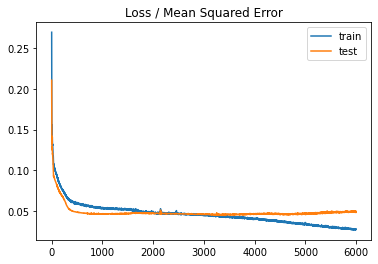

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units, dropout_prob, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    model.add(Dense(units=1))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss", monitor='val_loss', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    train_mse = model.evaluate(X_train, y_train)
    test_mse = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lstm_units, dropout_prob, epochs, batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [ ]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [ ]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss")

In [ ]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [ ]:
predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
y_test, predicted_stock_price

(array([[ 38.72000122],
        [ 28.71999931],
        [ 38.70000076],
        ...,
        [ 41.90000153],
        [144.27999878],
        [ 90.        ]]), array([[ 38.7004  ],
        [ 28.065823],
        [ 39.988865],
        ...,
        [ 40.68165 ],
        [142.07353 ],
        [ 89.45229 ]], dtype=float32))

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.02]
 [0.65]
 [-1.29]
 ...
 [1.22]
 [2.21]
 [0.55]]
[3224.14]


rmse: 88.9639416834328 mape: 1.8110645929806803
confusion_matrix: [[409   0 587]
 [  0   0   0]
 [393   0 607]]
acc: 0.5090180360721442


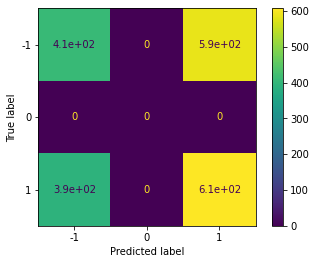

In [ ]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

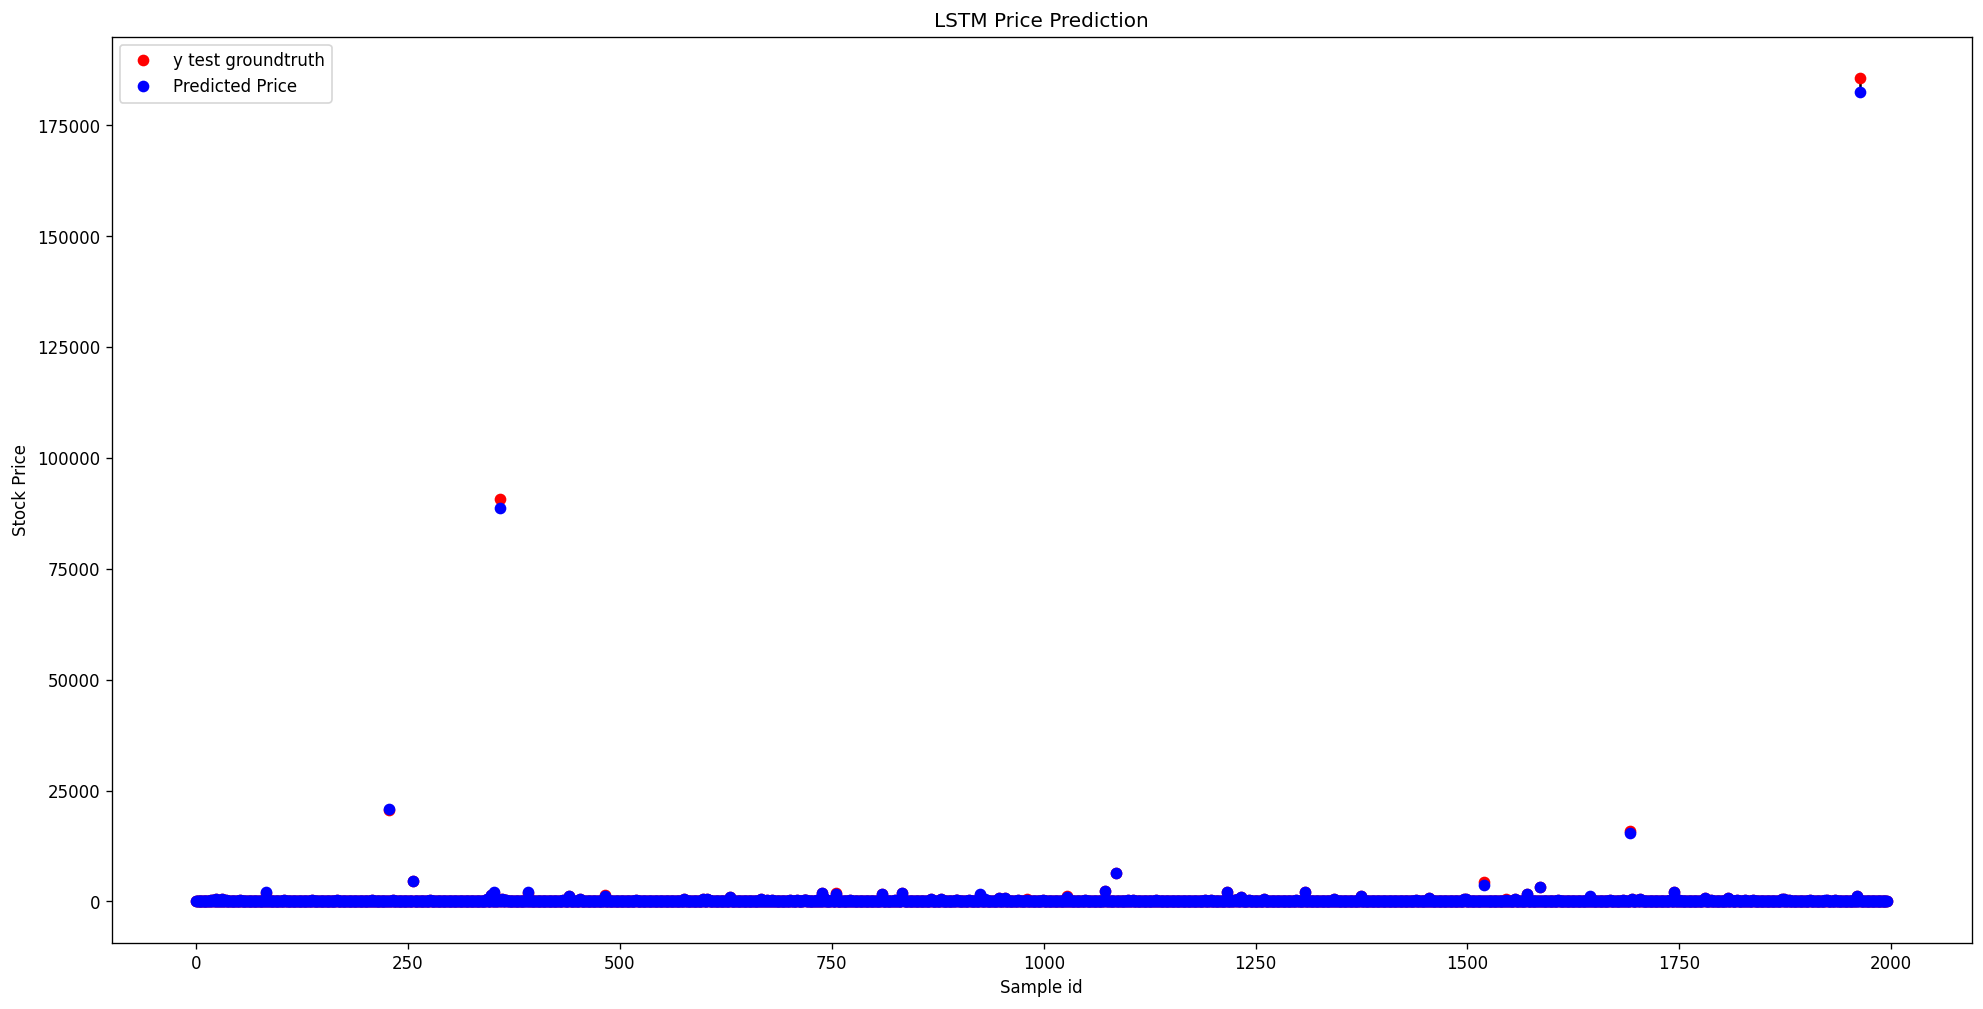

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [ ]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [ ]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[19:15:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [ ]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.03]
 [0.68]
 [-1.39]
 ...
 [1.22]
 [1.77]
 [0.44]]
[2795.70]


rmse: 90.10278867199361 mape: 1.8043343898316886
confusion_matrix: [[421   0 575]
 [  0   0   0]
 [420   0 580]]
acc: 0.501503006012024


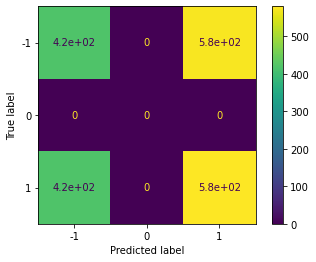

In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

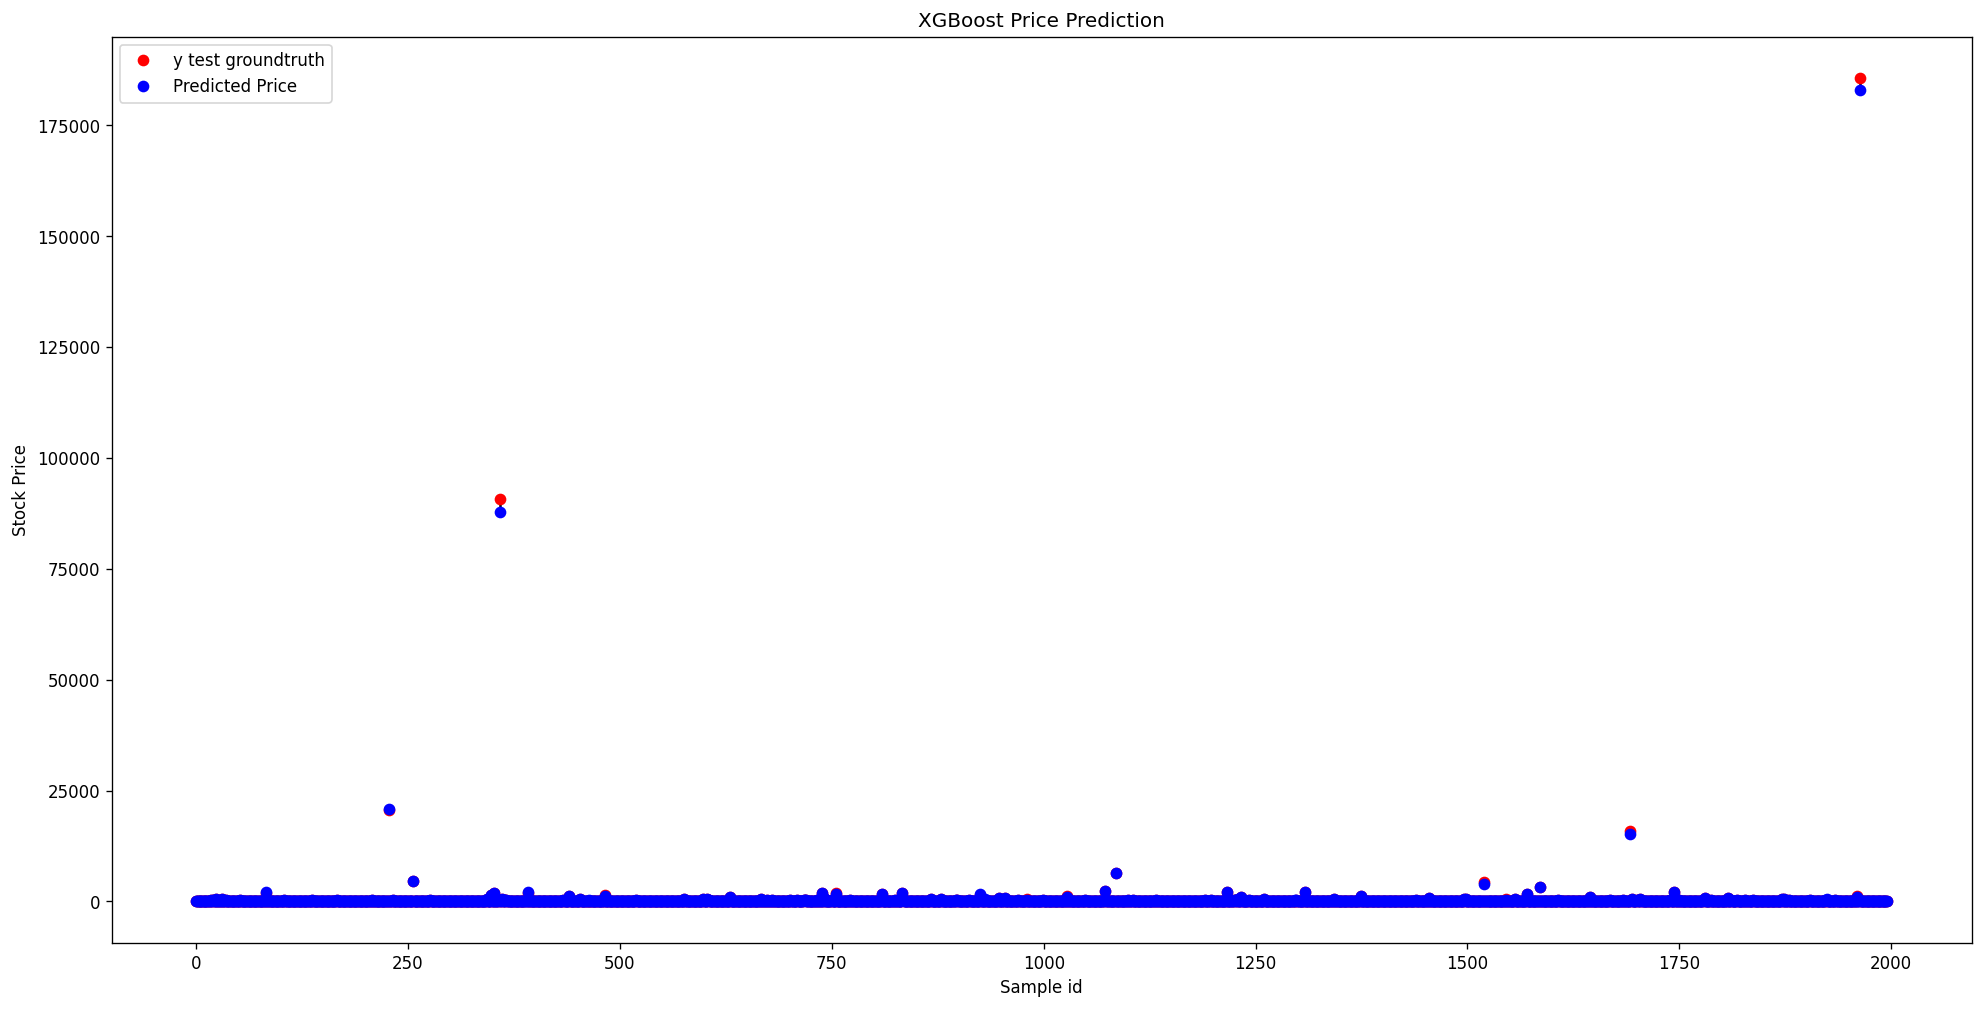

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()